**stage2_DANN**. This notebook is the initial attempt to train a DANN with UMAFall as source data and UPFall as target data.

**Edit**<br/>

**TODO**<br/>

# Import packages and get authenticated

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')

from utilities import *
from models import *
from dataset_util import *
from training_util import *
from eval_util import *

import time
import datetime
from datetime import datetime
import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Repeat 10 times experiment

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/

======================  train on source, val on target(source=UMAFall_chest to target=UPFall_ankle)  ======================

------------------------------Working on i_CV 0------------------------------
Working on get_UMAFall_loader...
train_data shape: (546, 3, 66)
val_data shape: (44, 3, 66)
Working on get_UPFall_loader...
train_data shape: (525, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
acc performance: 0.326007326007326 0.14285714285714285 0.43223443223443225 0.8736263736263736
acc performance: 0.4090909090909091 0.13636363636363635 0.3409090909090909 0.5681818181818182


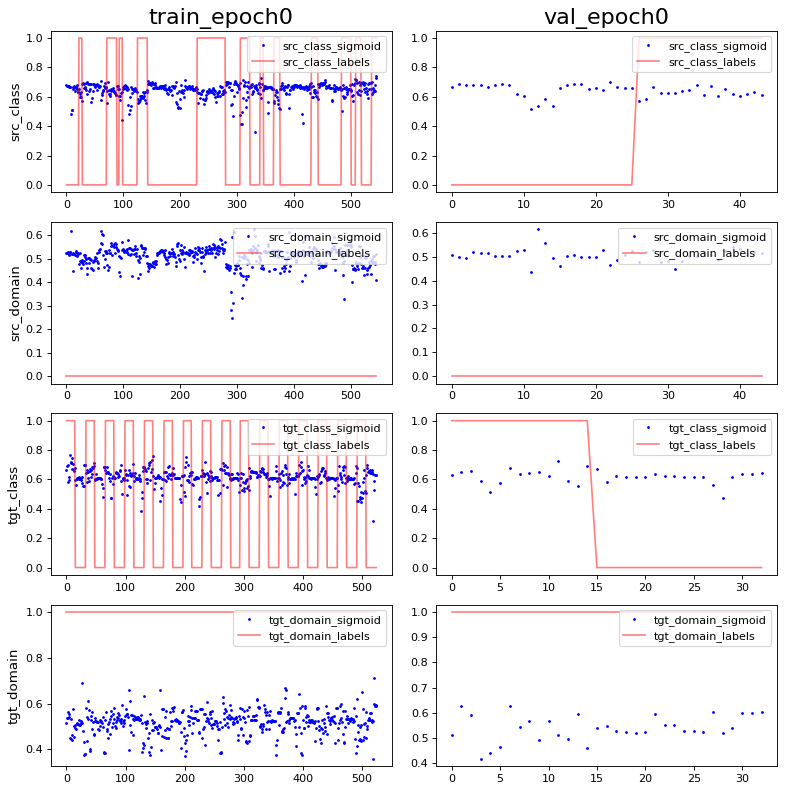

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
show standardize mean and std: 7.915131e-09 1.0
PCA var: [21.699999 34.199997 41.399998 47.1      51.6      55.1      58.1
 60.5      62.5      64.2     ]
show standardize mean and std: -6.1926904e-09 0.9965218
PCA var: [19.9      31.4      40.9      47.600002 54.000004 59.400005 63.500004
 67.3      71.       73.9     ]


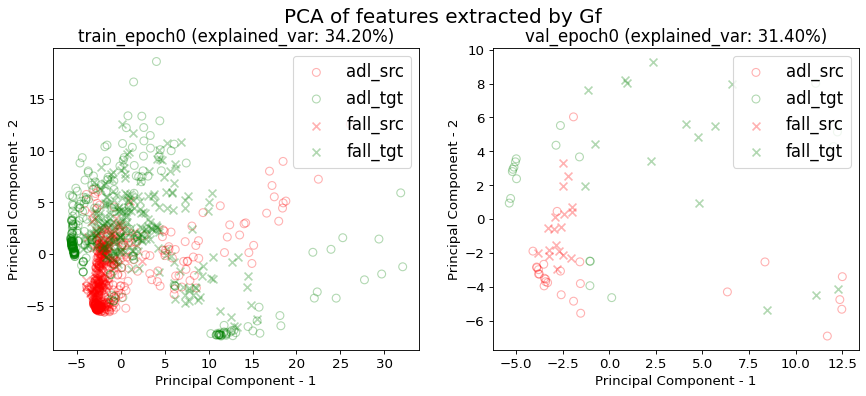

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/


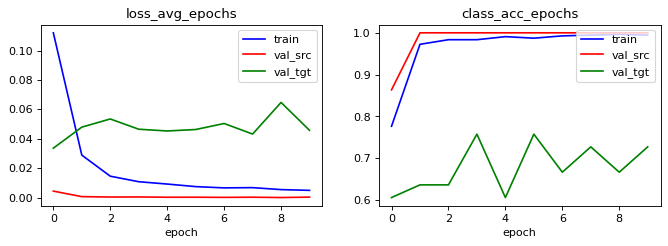

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
acc performance: 0.9926739926739927 0.0989010989010989 0.7362637362637363 0.7637362637362637
acc performance: 1.0 0.06818181818181818 0.5454545454545454 0.4318181818181818


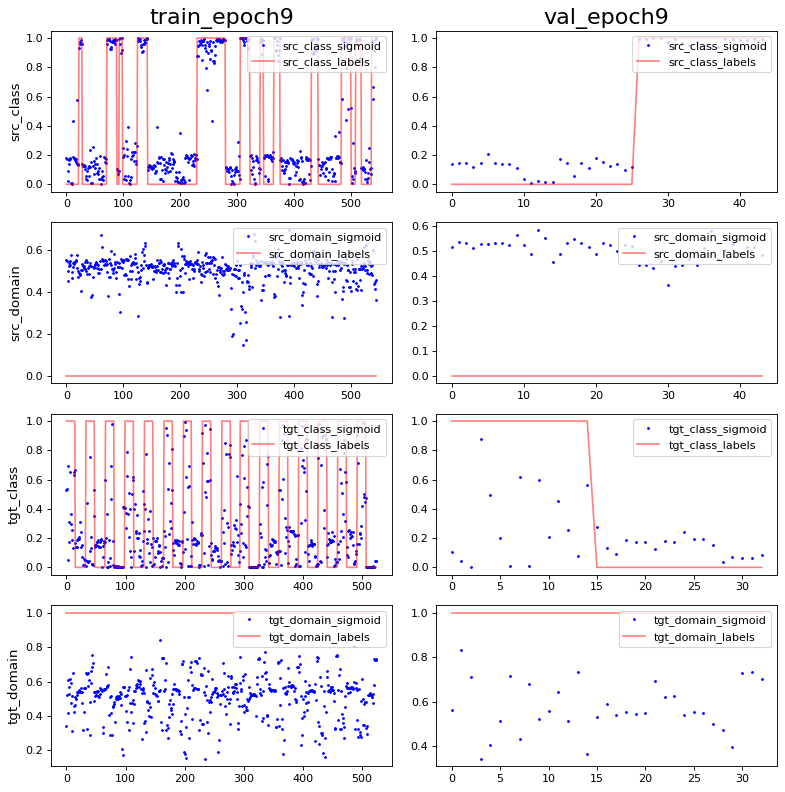

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
show standardize mean and std: -3.1660523e-09 1.0
PCA var: [29.300001 52.9      60.100002 65.       68.7      71.399994 73.59999
 75.19999  76.69999  77.89999 ]
show standardize mean and std: -5.5046137e-09 1.0
PCA var: [25.5      44.5      58.6      64.7      69.299995 72.899994 75.899994
 78.7      80.899994 82.899994]


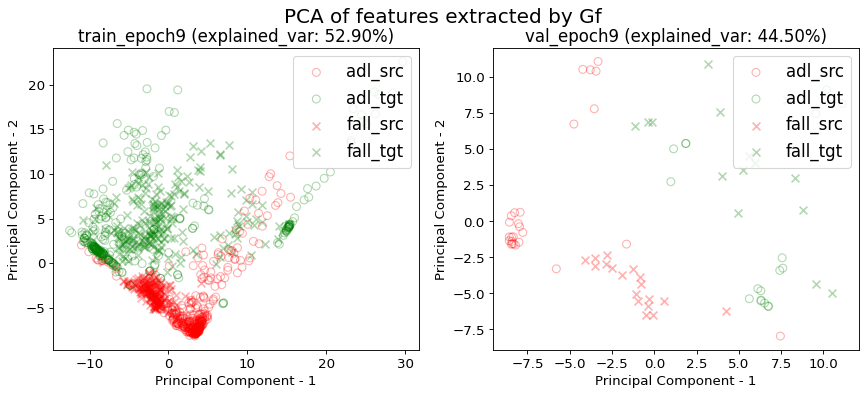

------------------------------Working on i_CV 1------------------------------
Working on get_UMAFall_loader...
train_data shape: (562, 3, 66)
val_data shape: (28, 3, 66)
Working on get_UPFall_loader...
train_data shape: (525, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
acc performance: 0.3238434163701068 0.0 0.40213523131672596 0.9341637010676157
acc performance: 0.21428571428571427 0.0 0.39285714285714285 1.1428571428571428


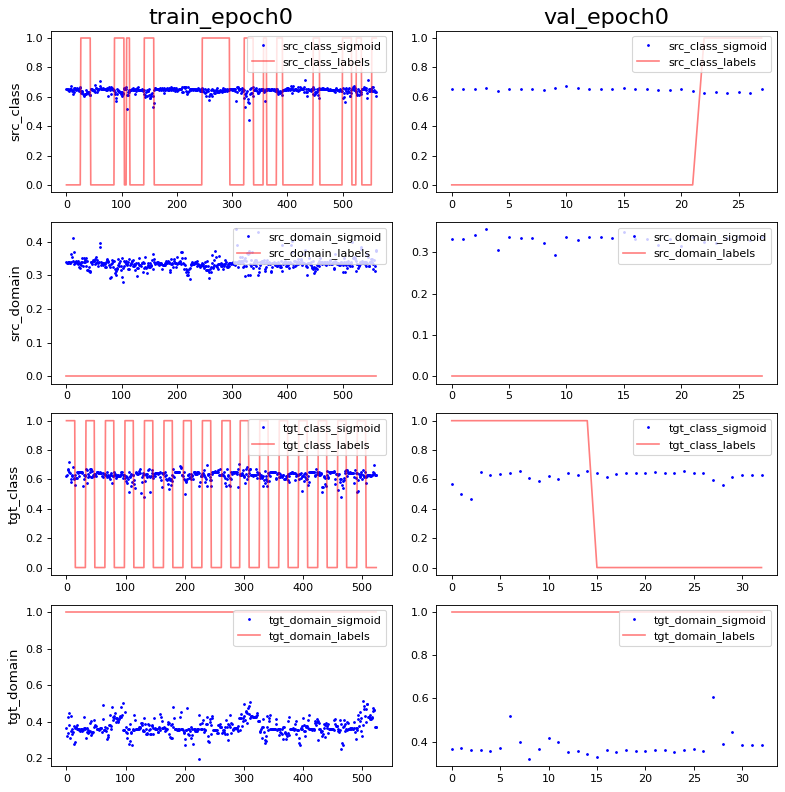

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_chest_UPFall_ankle/source/
show standardize mean and std: -3.1194498e-09 0.9895285
PCA var: [27.4      41.7      49.5      53.9      57.800003 61.000004 62.900005
 64.700005 66.4      67.9     ]
show standardize mean and std: 1.3896893e-08 0.9860133
PCA var: [27.8      46.4      57.5      65.8      71.8      75.700005 78.9
 81.8      84.100006 86.100006]


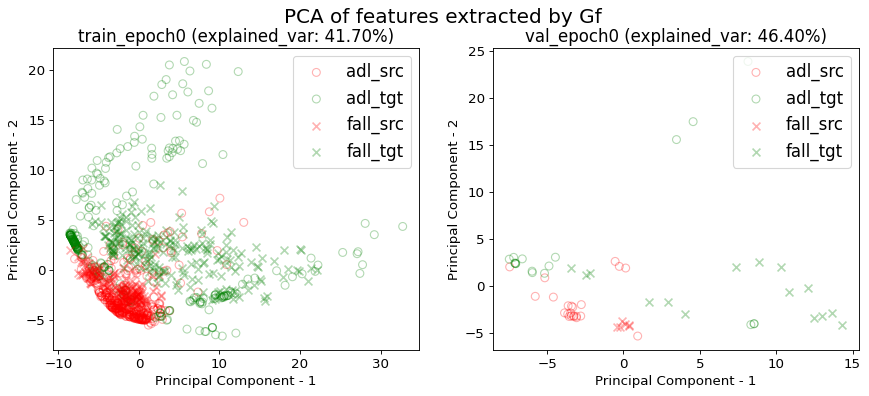

In [0]:
rep_n = 5

extractor_type = 'CNN'
num_epochs = 10
CV_n = 17

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


tasks_params_list = [

    
  { 'HP_name': 'opitmal',
    'task': ('UMAFall_chest', 'UPFall_ankle'),
    'classes_n': 2,
    'CV_n': CV_n,
    'num_epochs': num_epochs,
    'channel_n': 4,
    'batch_size': 4,
    'learning_rate': 0.001,
    'extractor_type': extractor_type,
    'device': device}, 

  { 'HP_name': 'opitmal',
    'task': ('UMAFall_leg', 'UPFall_wrist'),
    'classes_n': 2,
    'CV_n': CV_n,
    'num_epochs': num_epochs,
    'channel_n': 32,
    'batch_size': 64,
    'learning_rate': 0.001,
    'extractor_type': extractor_type,
    'device': device},
    
] 


for tasks_params in tasks_params_list:

  (src_name, tgt_name) = tasks_params['task']

  if 'rightpocket' in src_name or 'leg' in tgt_name or 'rightpocket' in tgt_name or 'leg' in src_name:
    tasks_params['CV_n'] = 15
  else:
    tasks_params['CV_n'] = 17


  inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
  outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/{}_{}/'.format(src_name, tgt_name)
  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
  print('outputdir for stage2 output:', outputdir)

  # df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
  for i in range(0,rep_n):
    start_time = time.time()
    df_performance_table = performance_table(src_name, tgt_name, tasks_params, inputdir, outputdir)
    time_elapsed = time.time() - start_time
    print('time elapsed:', time_elapsed)
    df_performance_table.loc['time_elapsed'] = time_elapsed

    # df_performance_table_agg['rep10_i{}.csv'.format(i)] = df_performance_table


    df_outputdir = outputdir+'repetitive_results/'
    if not os.path.exists(df_outputdir):
      os.makedirs(df_outputdir)
    print('df_performance_table saved at', outputdir)

    # Serialize data into file:
    json.dump({key:val for key, val in tasks_params.items() if key != 'device'}, open(df_outputdir+'optimal_training_params.json', 'w'))

    df_performance_table.to_csv(df_outputdir+'df_performance_table_rep10_i{}.csv'.format(i), encoding='utf-8')

    display(df_performance_table)


  df_performance_table_all = get_rep10_stats(df_outputdir, rep_n)
  display(df_performance_table_all)

In [0]:
# rep_n = 5

# extractor_type = 'CNN'
# num_epochs = 10
# CV_n = 17

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# tasks_params_list = [

    
#   { 'task': ('UMAFall_chest', 'UPFall_ankle'),
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 4,
#     'learning_rate': 0.001,
#     'extractor_type': extractor_type,
#     'device': device}, 

#   { 'task': ('UMAFall_leg', 'UPFall_wrist'),
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 32,
#     'batch_size': 64,
#     'learning_rate': 0.001,
#     'extractor_type': extractor_type,
#     'device': device},
    
# ] 


# for tasks_params in tasks_params_list:

#   (src_name, tgt_name) = tasks_params['task']

#   if 'rightpocket' in src_name or 'leg' in tgt_name or 'rightpocket' in tgt_name or 'leg' in src_name:
#     tasks_params['CV_n'] = 15
#   else:
#     tasks_params['CV_n'] = 17


#   inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
#   outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/{}_{}/'.format(src_name, tgt_name)
#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)
#   print('outputdir for stage2 output:', outputdir)

#   # df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
#   for i in range(0,rep_n):
#     start_time = time.time()
#     df_performance_table = performance_table(src_name, tgt_name, tasks_params, inputdir, outputdir)
#     time_elapsed = time.time() - start_time
#     print('time elapsed:', time_elapsed)
#     df_performance_table.loc['time_elapsed'] = time_elapsed

#     # df_performance_table_agg['rep10_i{}.csv'.format(i)] = df_performance_table


#     df_outputdir = outputdir+'repetitive_results/'
#     if not os.path.exists(df_outputdir):
#       os.makedirs(df_outputdir)
#     print('df_performance_table saved at', outputdir)

#     # Serialize data into file:
#     json.dump({key:val for key, val in tasks_params.items() if key != 'device'}, open(df_outputdir+'optimal_training_params.json', 'w'))

#     df_performance_table.to_csv(df_outputdir+'df_performance_table_rep10_i{}.csv'.format(i), encoding='utf-8')

#     display(df_performance_table)


#   df_performance_table_all = get_rep10_stats(df_outputdir, rep_n)
#   display(df_performance_table_all)

In [0]:
# del tasks_params['device']
# tasks_params

{key:val for key, val in tasks_params.items() if key != 'CV_n'}, tasks_params

({'batch_size': 16,
  'channel_n': 4,
  'classes_n': 2,
  'extractor_type': 'CNN',
  'learning_rate': 0.01,
  'num_epochs': 2,
  'task': ('UMAFall_ankle', 'UPFall_rightpocket')},
 {'CV_n': 2,
  'batch_size': 16,
  'channel_n': 4,
  'classes_n': 2,
  'extractor_type': 'CNN',
  'learning_rate': 0.01,
  'num_epochs': 2,
  'task': ('UMAFall_ankle', 'UPFall_rightpocket')})

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/

======================  train on source, val on target(source=UMAFall_wrist to target=UPFall_rightpocket)  ======================

------------------------------Working on i_CV 0------------------------------
Working on get_UMAFall_loader...
train_data shape: (547, 3, 66)
val_data shape: (44, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.6782449725776966 0.870201096892139 0.4643510054844607 0.15539305301645337
acc performance: 0.5454545454545454 0.75 0.36363636363636365 0.20454545454545456


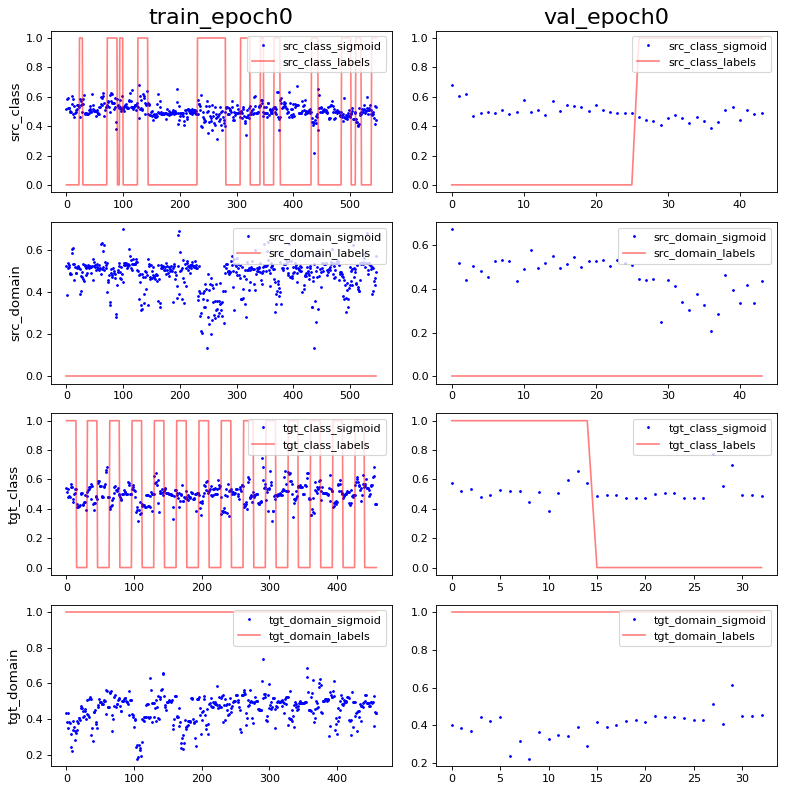

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -3.3706182e-09 0.99999994
PCA var: [23.9      34.4      42.2      49.       53.7      58.3      60.899998
 63.3      65.4      67.200005]
show standardize mean and std: -1.3761534e-09 1.0
PCA var: [26.499998 41.       51.       58.       63.6      68.9      73.5
 76.5      79.3      81.600006]


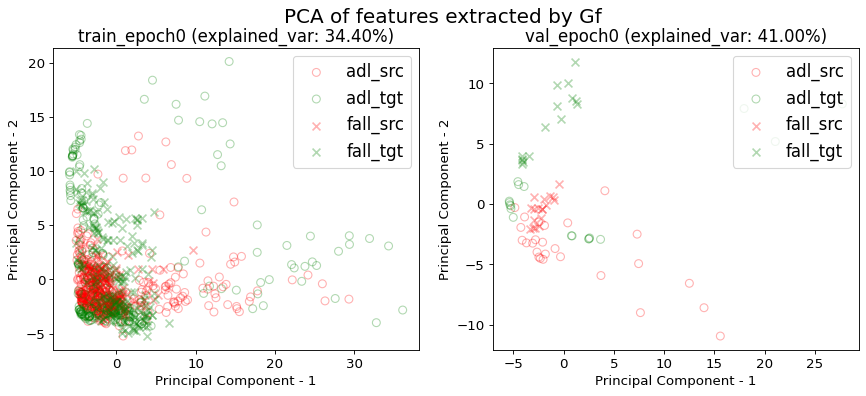

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


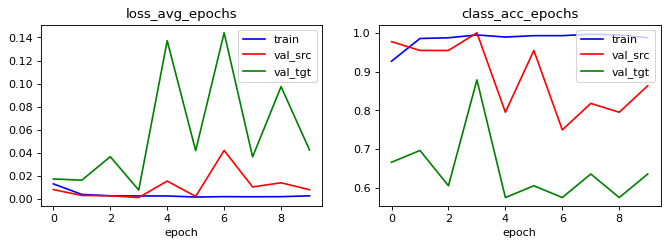

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.9579524680073126 0.9872029250457038 0.5959780621572212 0.007312614259597806
acc performance: 0.8636363636363636 0.9772727272727273 0.4772727272727273 0.022727272727272728


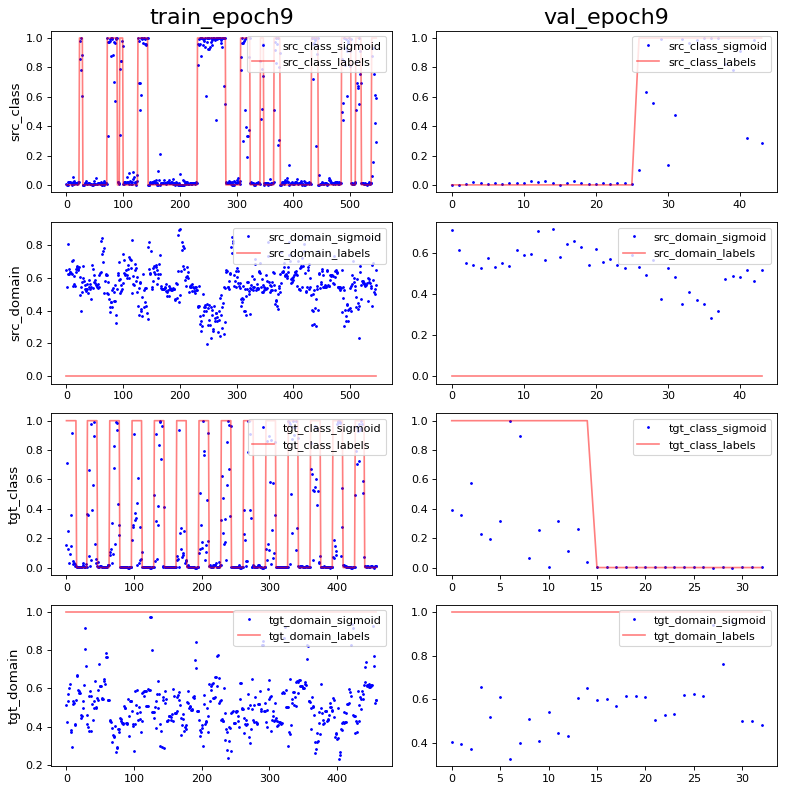

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 1.0954509e-08 1.0
PCA var: [26.300001 46.2      53.600002 59.500004 63.800003 66.8      68.9
 70.9      72.700005 74.3     ]
show standardize mean and std: 0.0 1.0
PCA var: [41.9      54.2      63.6      70.799995 76.299995 80.799995 83.7
 86.2      88.299995 89.799995]


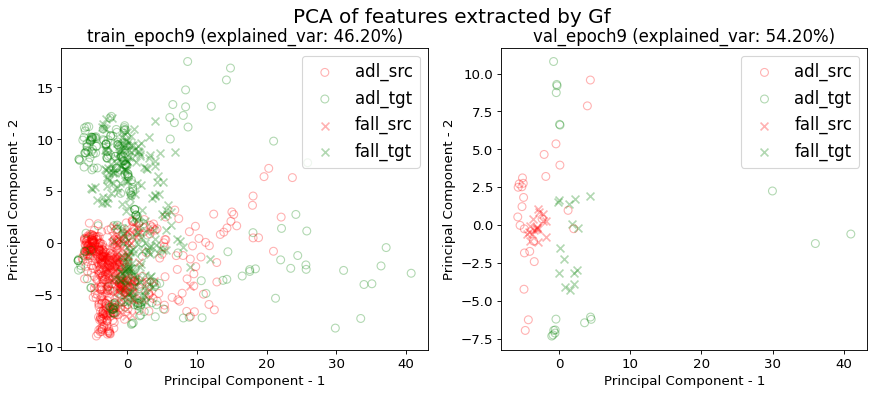

------------------------------Working on i_CV 1------------------------------
Working on get_UMAFall_loader...
train_data shape: (562, 3, 66)
val_data shape: (29, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (31, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.34341637010676157 0.010676156583629894 0.3736654804270463 0.7793594306049823
acc performance: 0.20689655172413793 0.0 0.5517241379310345 1.0344827586206897


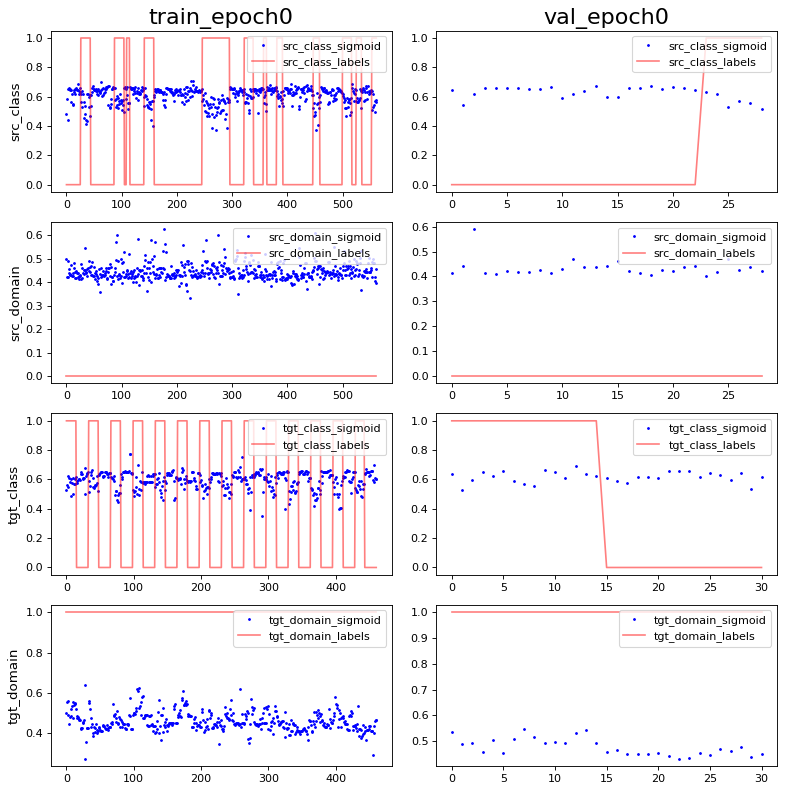

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -2.9002802e-09 0.98952854
PCA var: [17.800001 27.2      34.2      40.9      44.9      48.300003 51.300003
 53.600002 55.800003 57.700005]
show standardize mean and std: -8.8303176e-10 0.9895286
PCA var: [20.5      37.7      48.       53.6      58.399998 62.399998 65.799995
 68.99999  71.799995 74.299995]


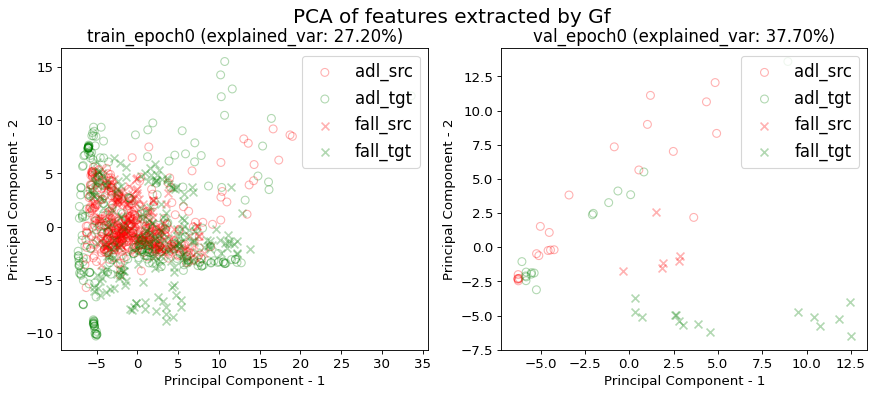

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


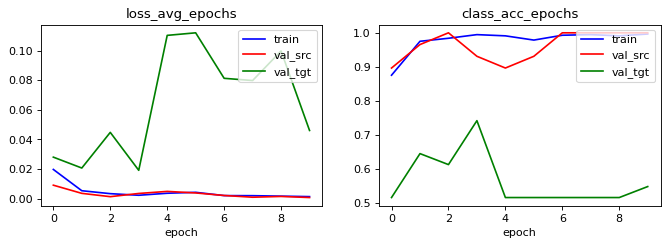

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.998220640569395 0.5427046263345195 0.7046263345195729 0.06761565836298933
acc performance: 1.0 0.4827586206896552 0.5862068965517241 0.0


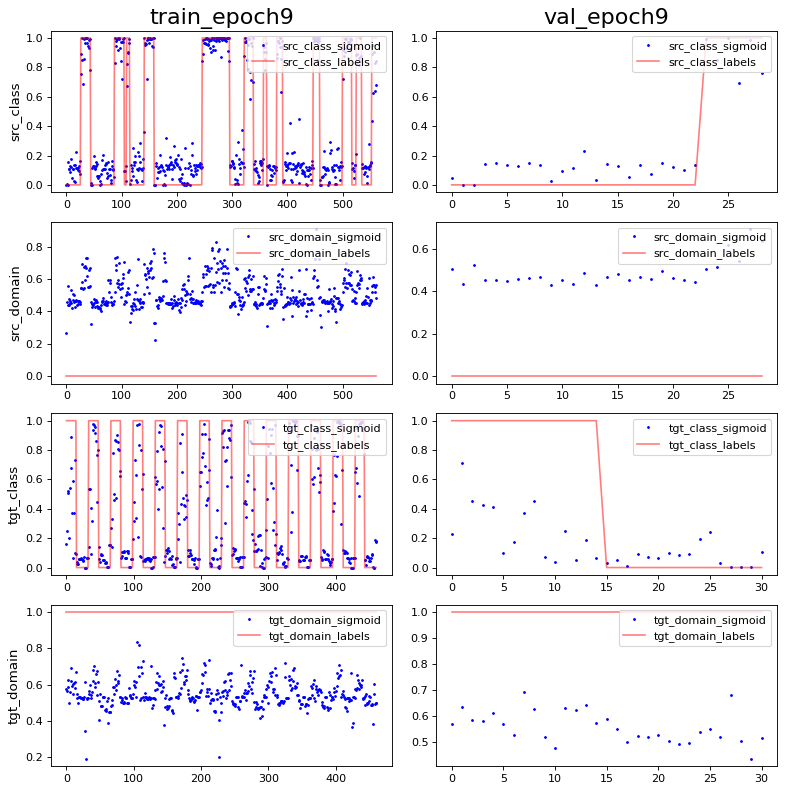

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 3.1074432e-10 0.9965218
PCA var: [31.400002 43.100002 50.800003 57.800003 62.000004 65.5      67.7
 69.6      71.299995 72.7     ]
show standardize mean and std: 0.0 0.9965218
PCA var: [36.3      48.5      59.6      65.9      70.8      74.100006 77.00001
 79.50001  81.80001  83.90001 ]


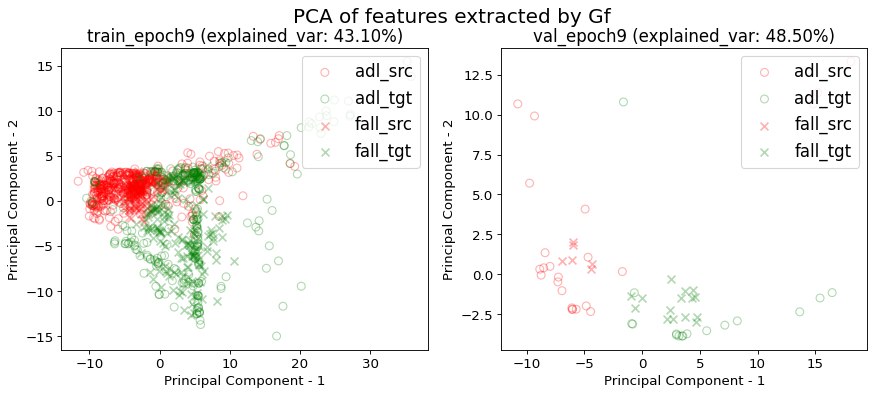

------------------------------Working on i_CV 2------------------------------
Working on get_UMAFall_loader...
train_data shape: (562, 3, 66)
val_data shape: (29, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.6476868327402135 0.9110320284697508 0.44483985765124556 0.06583629893238434
acc performance: 1.0 1.0 0.6551724137931034 0.06896551724137931


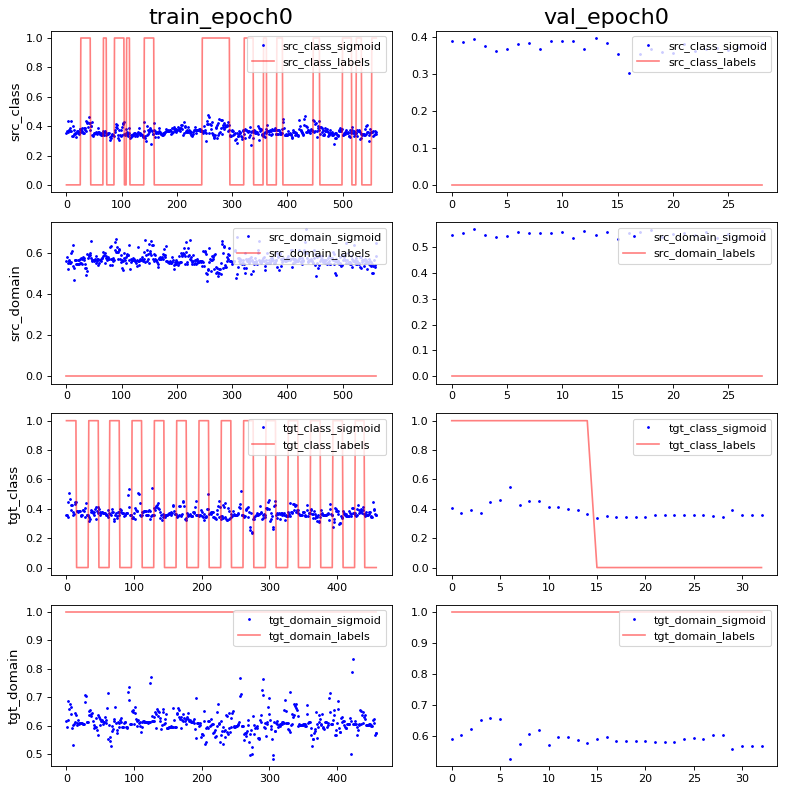

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 3.5286676e-09 0.9965218
PCA var: [18.7 32.5 42.  47.3 52.1 56.  58.5 60.8 63.  65. ]
show standardize mean and std: -3.4181875e-09 0.9965218
PCA var: [24.5      40.1      53.199997 60.299995 65.899994 70.2      74.1
 77.799995 80.299995 82.7     ]


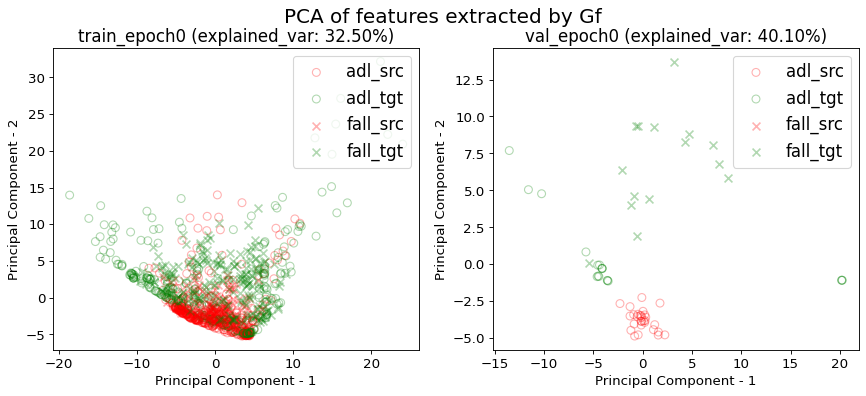

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


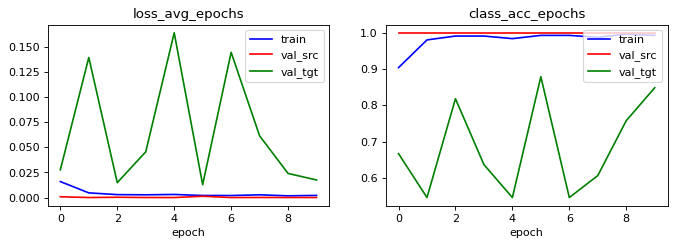

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.8380782918149466 0.6227758007117438 0.5854092526690391 0.3879003558718861
acc performance: 1.0 0.896551724137931 0.9655172413793104 0.3793103448275862


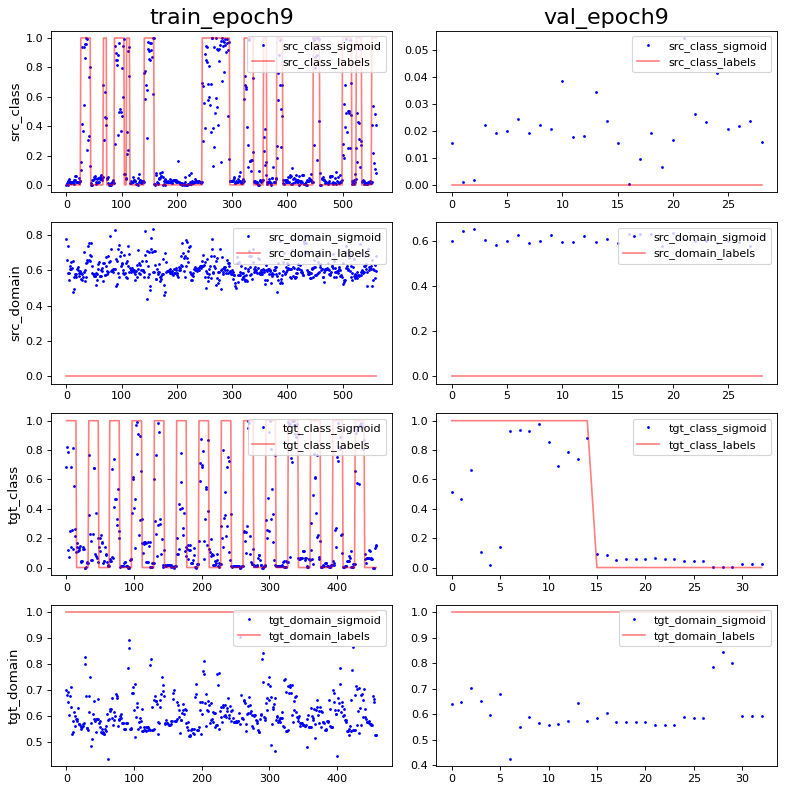

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 1.2454121e-09 1.0
PCA var: [22.400002 40.9      49.4      56.2      61.800003 64.9      67.8
 69.700005 71.200005 72.600006]
show standardize mean and std: 1.7090938e-09 0.9965218
PCA var: [24.       43.4      56.600002 67.3      73.5      77.3      80.200005
 82.8      85.100006 87.100006]


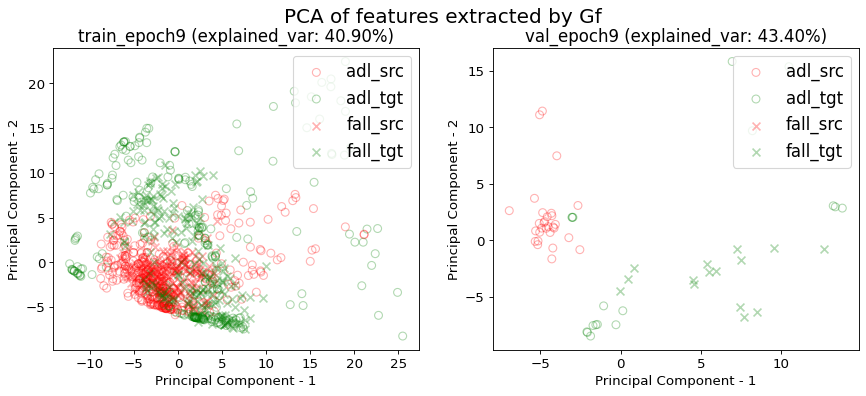

------------------------------Working on i_CV 3------------------------------
Working on get_UMAFall_loader...
train_data shape: (559, 3, 66)
val_data shape: (32, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.44543828264758495 0.4543828264758497 0.407871198568873 0.3595706618962433
acc performance: 0.34375 0.4375 0.3125 0.53125


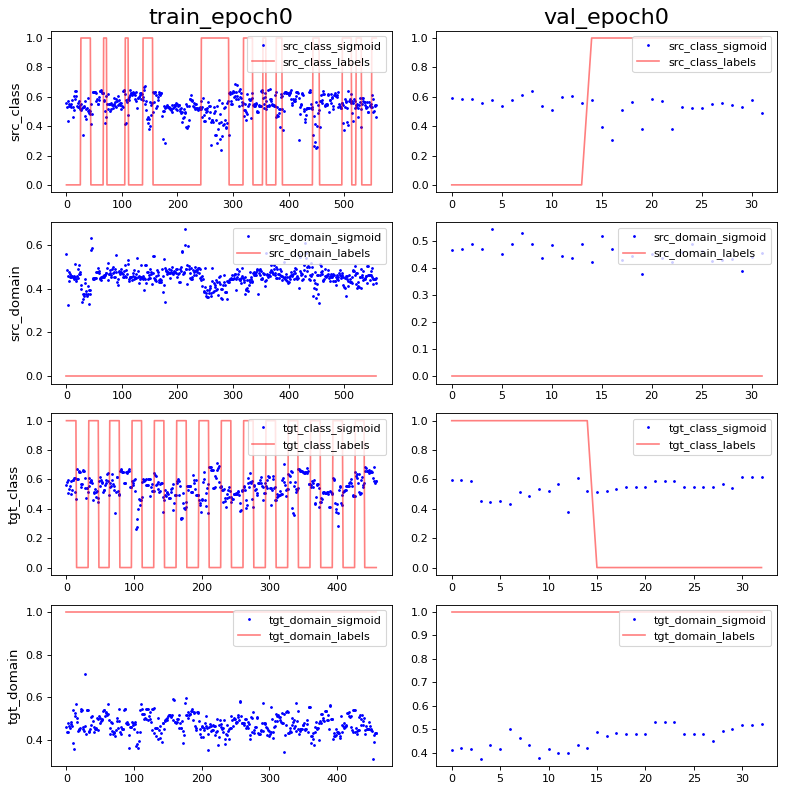

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -8.327215e-10 1.0
PCA var: [22.8      32.       41.1      46.899998 50.899998 54.699997 57.999996
 60.799995 62.999996 64.7     ]
show standardize mean and std: 7.74351e-09 1.0
PCA var: [17.       31.5      42.5      50.1      57.399998 63.       66.5
 69.8      73.       75.4     ]


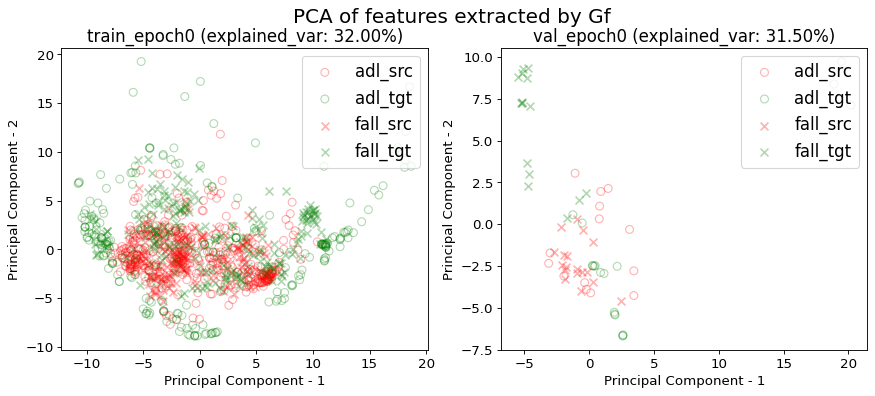

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


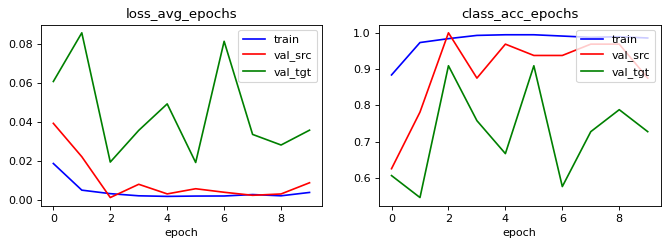

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.964221824686941 0.9803220035778175 0.5116279069767442 0.0
acc performance: 0.875 1.0 0.75 0.0


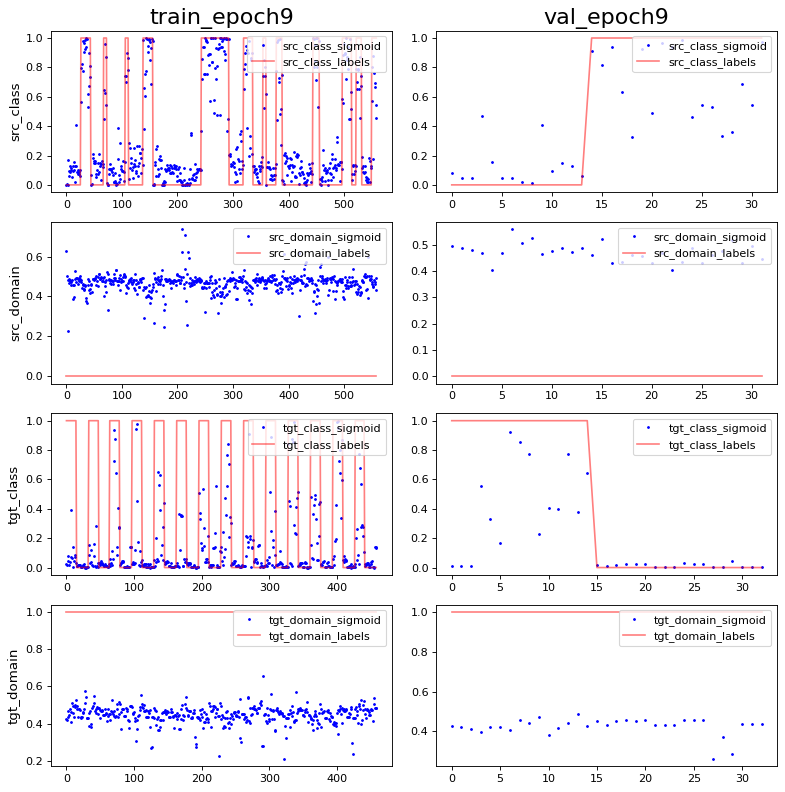

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 3.330886e-09 1.0
PCA var: [30.199999 40.699997 48.1      53.6      57.699997 60.499996 62.699997
 64.5      66.1      67.6     ]
show standardize mean and std: 0.0 0.98952854
PCA var: [31.8      42.9      51.9      59.800003 65.200005 69.50001  73.50001
 76.600006 79.3      81.9     ]


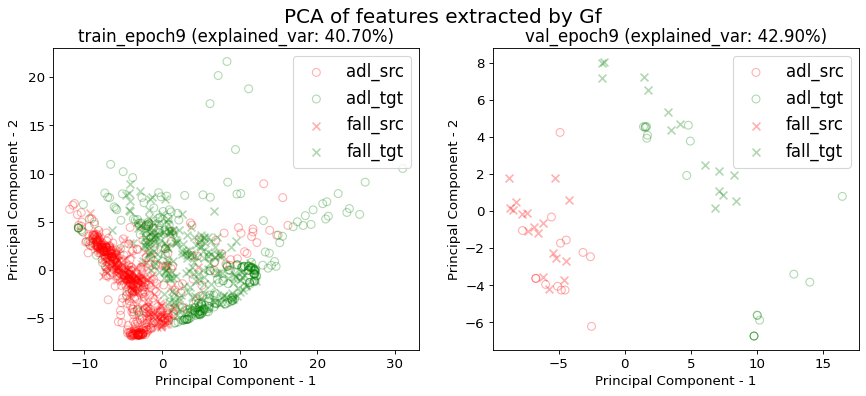

------------------------------Working on i_CV 4------------------------------
Working on get_UMAFall_loader...
train_data shape: (581, 3, 66)
val_data shape: (10, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3304647160068847 0.9208261617900172 0.35972461273666095 0.0378657487091222
acc performance: 0.6 1.0 1.5 0.6


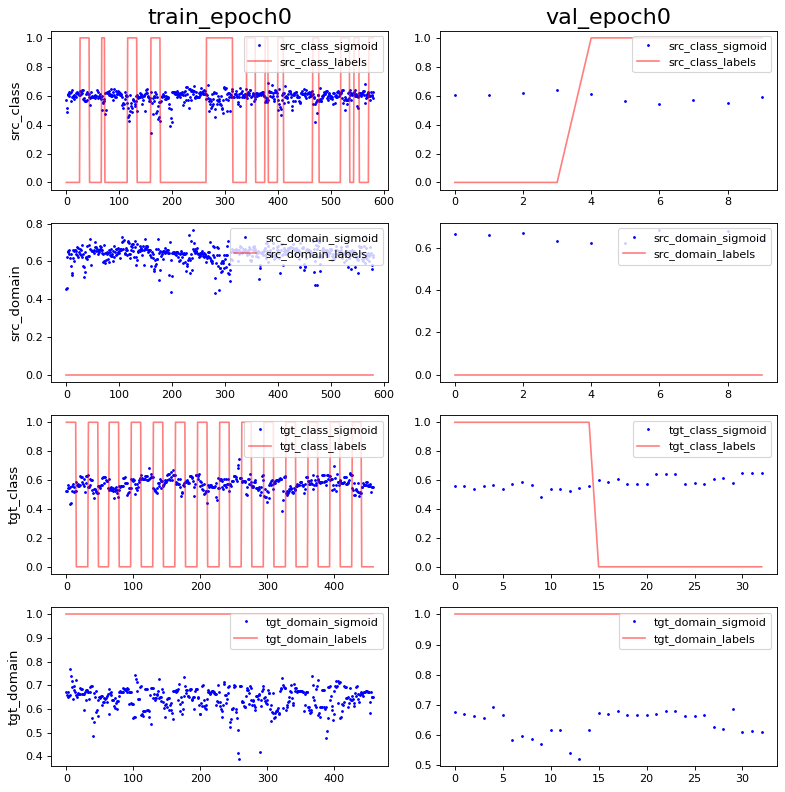

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -6.113297e-10 0.99303126
PCA var: [20.800001 34.5      41.6      47.399998 52.399998 56.399998 59.8
 62.399998 64.1      65.6     ]
show standardize mean and std: -4.9285496e-09 0.98952854
PCA var: [22.1      42.2      60.4      67.4      73.8      78.600006 83.100006
 86.3      88.4      90.3     ]


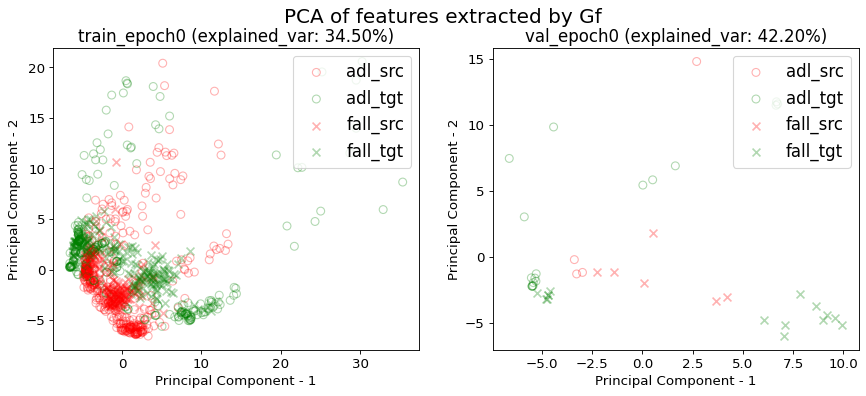

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


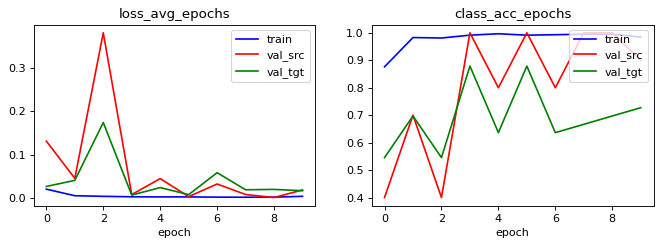

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.8209982788296041 0.0 0.5197934595524957 0.7900172117039587
acc performance: 0.9 0.0 2.4 3.3


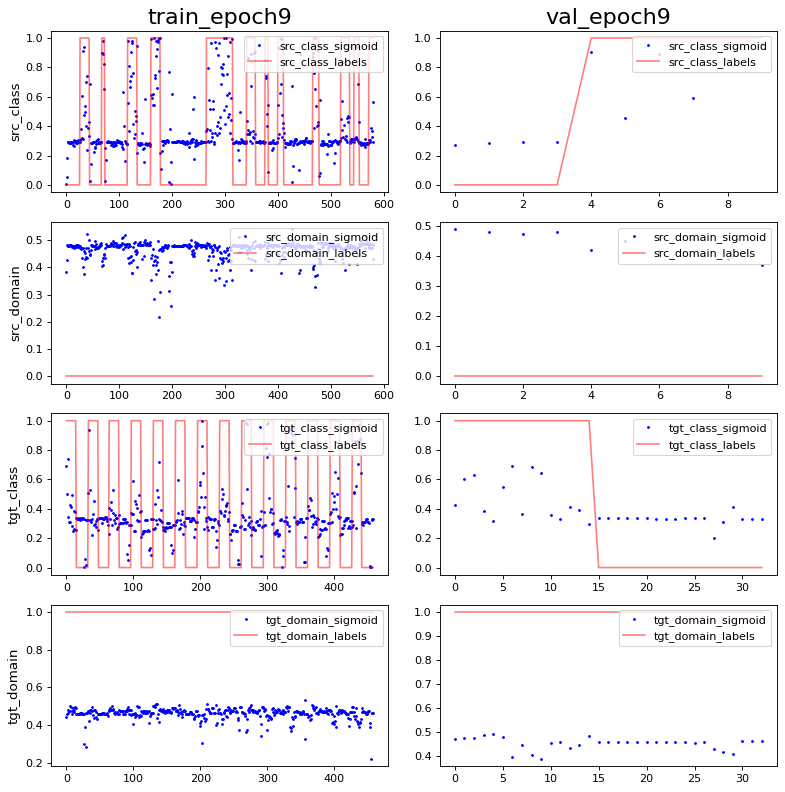

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 3.260425e-09 1.0
PCA var: [27.5      42.6      48.699997 53.199997 56.6      59.8      62.899998
 65.399994 67.7      69.899994]
show standardize mean and std: 6.1606866e-09 0.8700255
PCA var: [36.8      53.5      62.9      71.3      78.5      82.9      85.9
 88.4      90.4      92.200005]


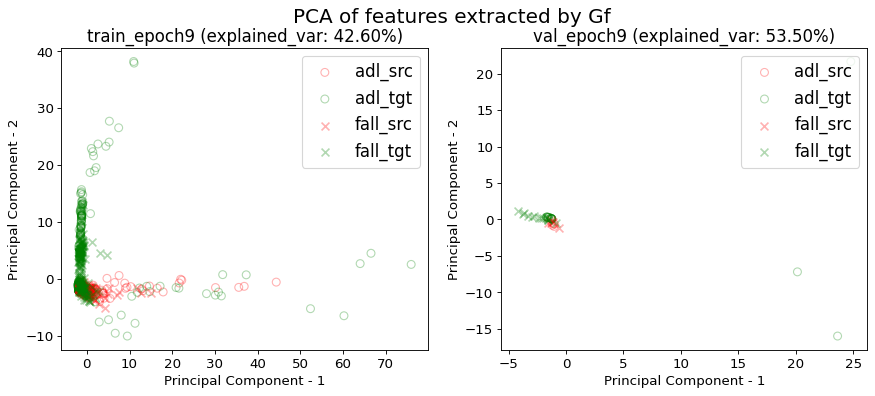

------------------------------Working on i_CV 5------------------------------
Working on get_UMAFall_loader...
train_data shape: (547, 3, 66)
val_data shape: (44, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.696526508226691 0.06946983546617916 0.5009140767824497 0.8043875685557587
acc performance: 0.7045454545454546 0.25 0.5681818181818182 0.7045454545454546


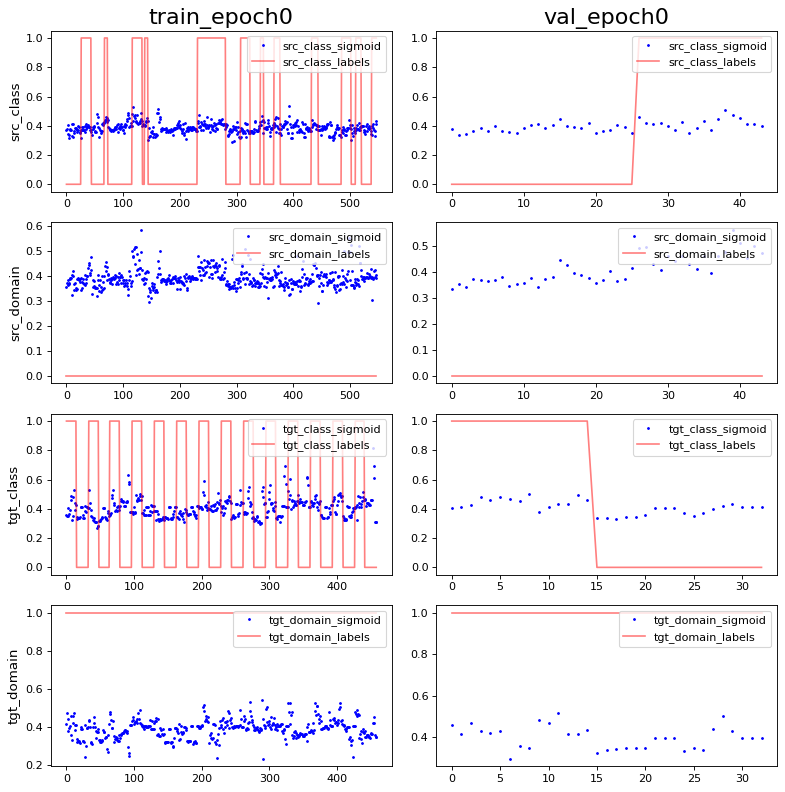

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 0.0 0.99999994
PCA var: [25.9      36.6      44.3      48.7      52.600002 56.300003 59.800003
 63.100002 65.700005 67.9     ]
show standardize mean and std: 2.7523068e-09 0.98952854
PCA var: [20.6      33.6      42.       49.6      56.199997 61.299995 66.1
 69.799995 72.99999  75.69999 ]


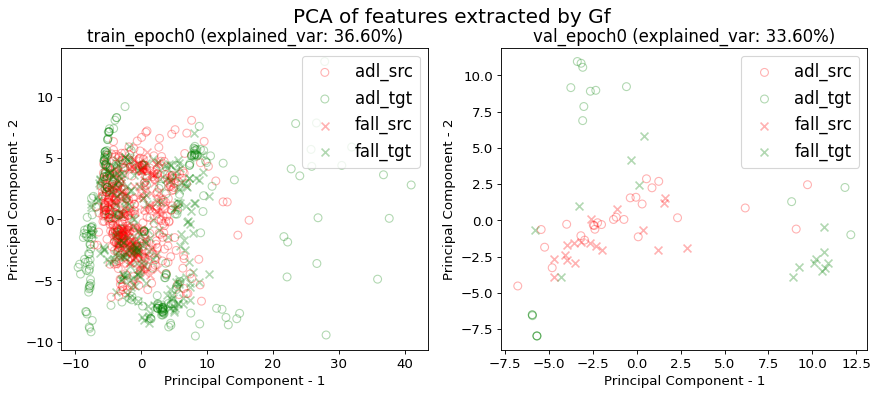

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


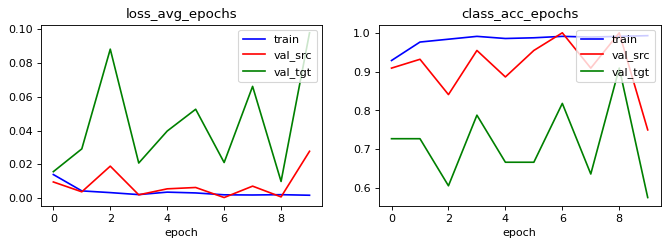

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.8336380255941499 0.2230347349177331 0.4936014625228519 0.603290676416819
acc performance: 0.75 0.2727272727272727 0.4318181818181818 0.5681818181818182


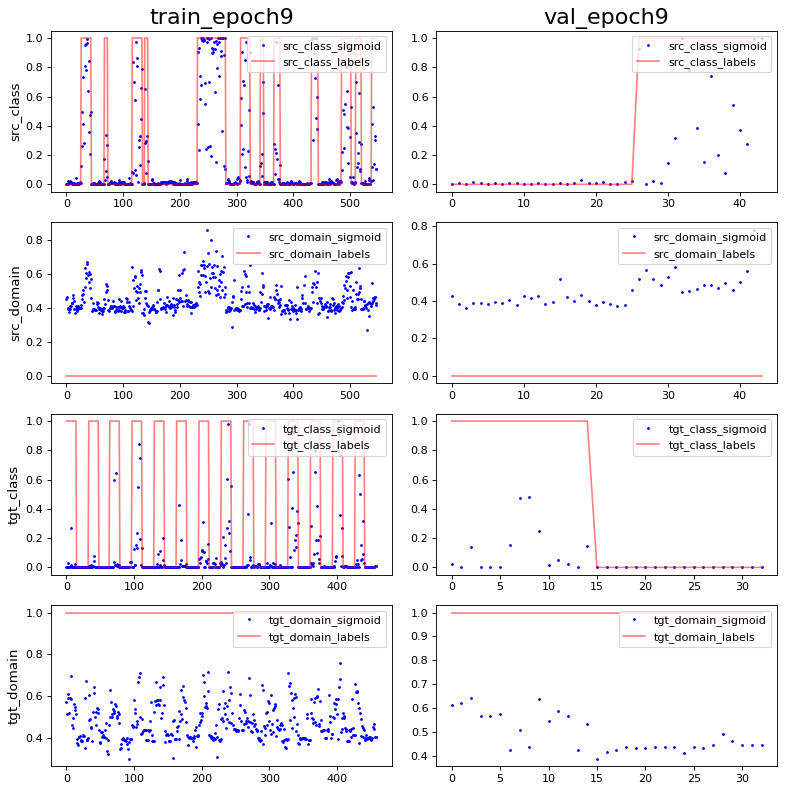

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -5.898582e-09 0.99999994
PCA var: [40.8      47.8      53.2      57.9      61.800003 64.4      66.8
 69.100006 71.200005 73.00001 ]
show standardize mean and std: -5.5046137e-09 0.98952854
PCA var: [38.800003 48.000004 56.200005 62.400005 67.700005 71.50001  74.50001
 77.00001  79.200005 81.00001 ]


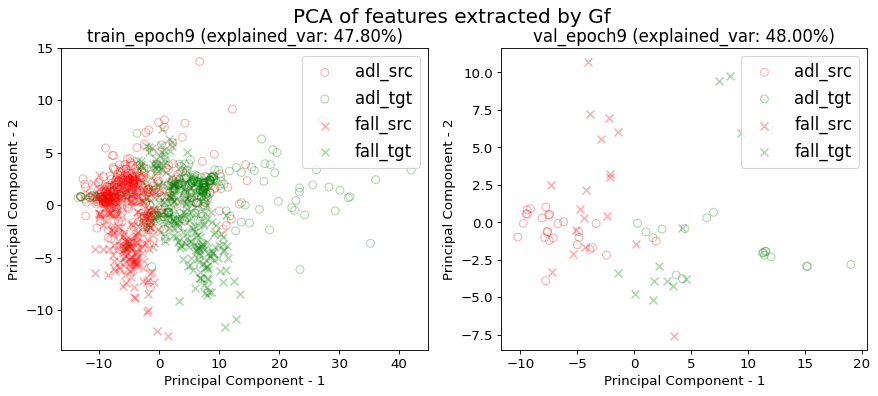

------------------------------Working on i_CV 6------------------------------
Working on get_UMAFall_loader...
train_data shape: (575, 3, 66)
val_data shape: (16, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3443478260869565 0.16 0.3634782608695652 0.7182608695652174
acc performance: 0.0 0.0 0.9375 1.8125


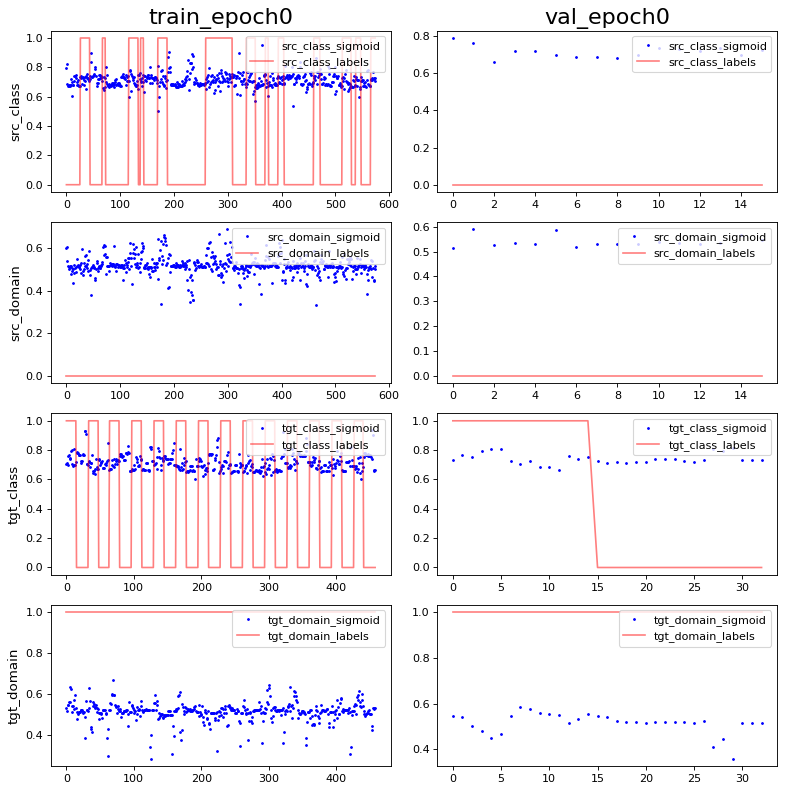

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 0.0 0.99999994
PCA var: [30.199999 38.8      45.3      49.7      53.600002 56.100002 58.500004
 60.600002 62.600002 64.5     ]
show standardize mean and std: -4.3250536e-09 1.0
PCA var: [30.7      46.2      55.4      63.9      68.8      73.100006 77.00001
 80.100006 83.100006 85.700005]


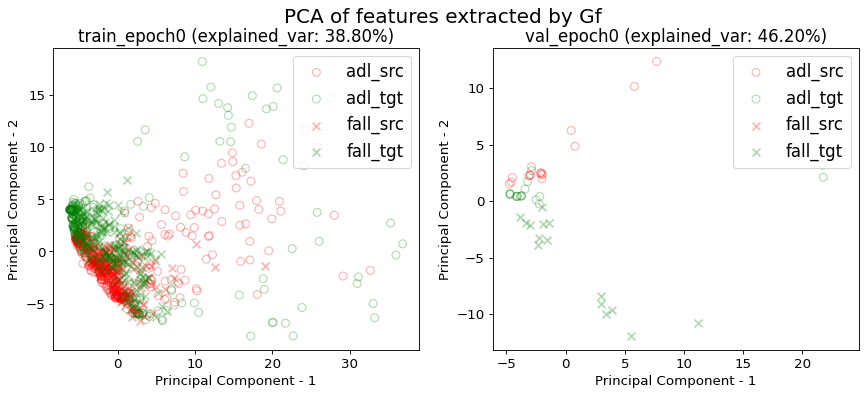

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


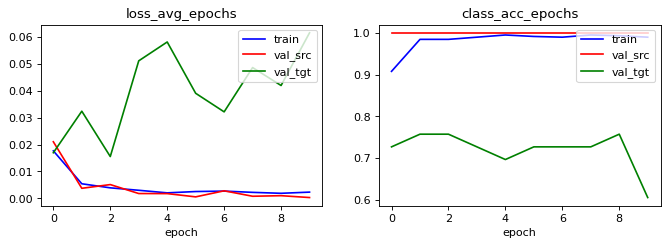

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.9686956521739131 0.19478260869565217 0.5860869565217391 0.6417391304347826
acc performance: 1.0 0.0 1.25 1.8125


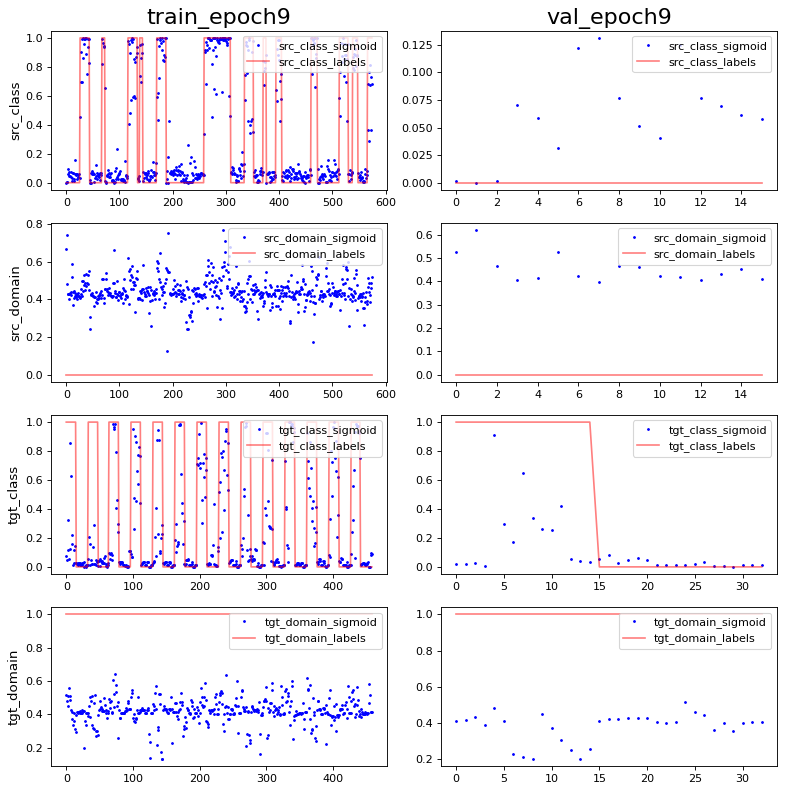

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 2.0495903e-09 1.0
PCA var: [36.399998 48.6      56.1      60.899998 64.1      66.799995 69.2
 71.2      72.899994 74.49999 ]
show standardize mean and std: -1.7300215e-08 1.0
PCA var: [44.3      58.1      66.1      73.2      78.2      82.799995 85.6
 87.9      89.700005 91.4     ]


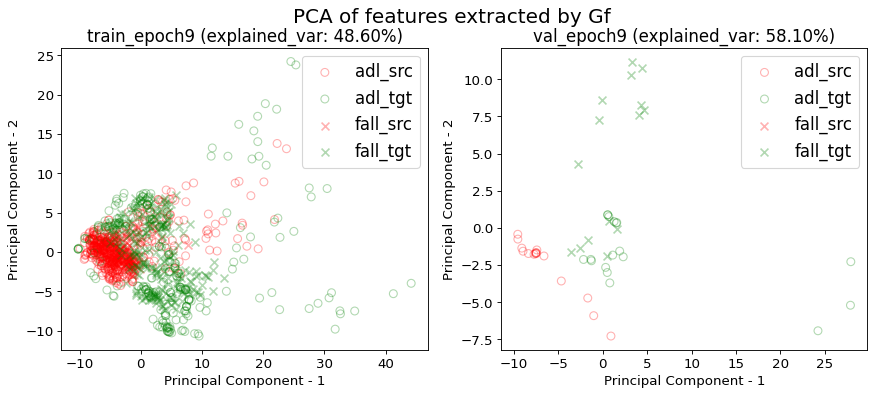

------------------------------Working on i_CV 7------------------------------
Working on get_UMAFall_loader...
train_data shape: (470, 3, 66)
val_data shape: (121, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.4957446808510638 0.9574468085106383 0.4702127659574468 0.019148936170212766
acc performance: 0.371900826446281 0.8099173553719008 0.1652892561983471 0.03305785123966942


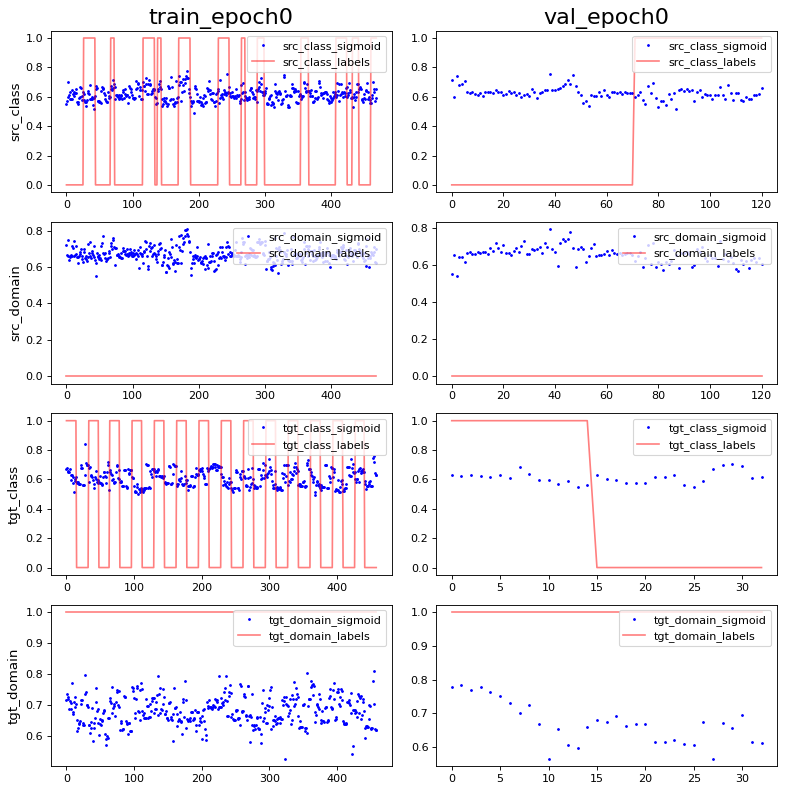

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -1.482809e-09 0.99652183
PCA var: [24.5      35.2      42.9      49.100002 53.2      56.3      58.899998
 60.899998 62.699997 64.5     ]
show standardize mean and std: -1.3761534e-09 0.99303126
PCA var: [26.699999 40.3      47.       52.5      57.7      61.7      65.1
 68.1      70.4      72.6     ]


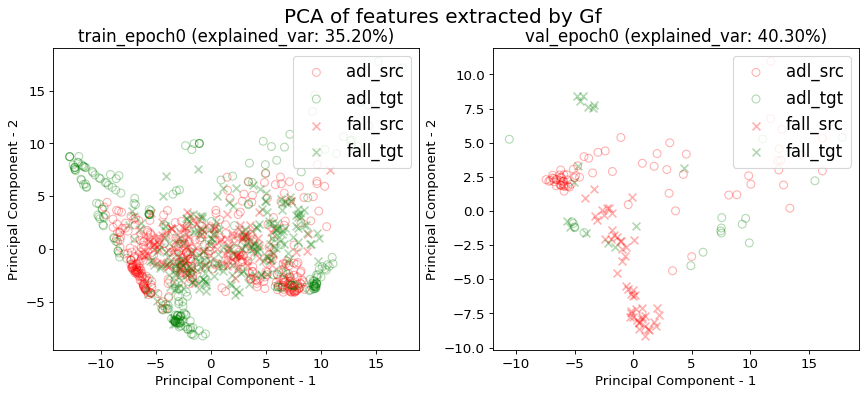

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


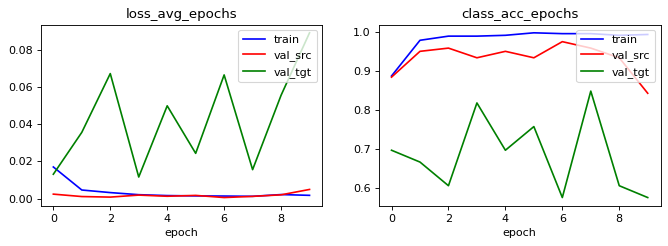

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.7851063829787234 0.9914893617021276 0.5723404255319149 0.006382978723404255
acc performance: 0.8429752066115702 0.9917355371900827 0.15702479338842976 0.0


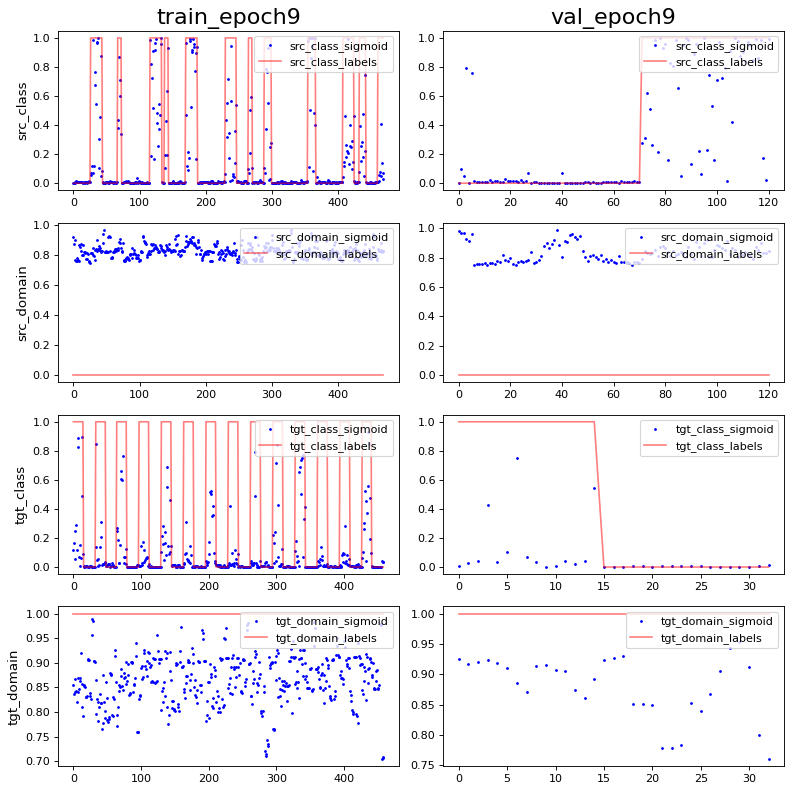

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -1.3687468e-09 0.8660254
PCA var: [26.300001 36.5      43.9      49.5      53.5      57.1      60.399998
 62.8      65.1      67.299995]
show standardize mean and std: -2.7523068e-09 0.8660254
PCA var: [31.8 40.8 48.6 55.8 60.6 65.  68.5 71.5 73.9 76.3]


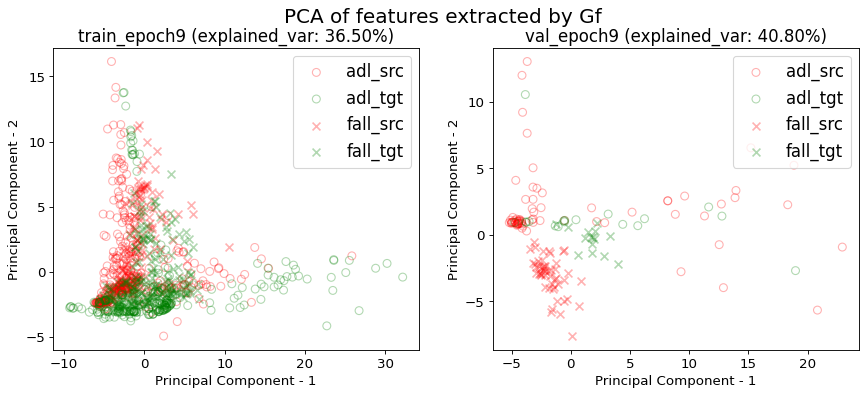

------------------------------Working on i_CV 8------------------------------
Working on get_UMAFall_loader...
train_data shape: (548, 3, 66)
val_data shape: (43, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.33211678832116787 0.04562043795620438 0.3813868613138686 0.718978102189781
acc performance: 0.3953488372093023 0.023255813953488372 0.3488372093023256 0.6976744186046512


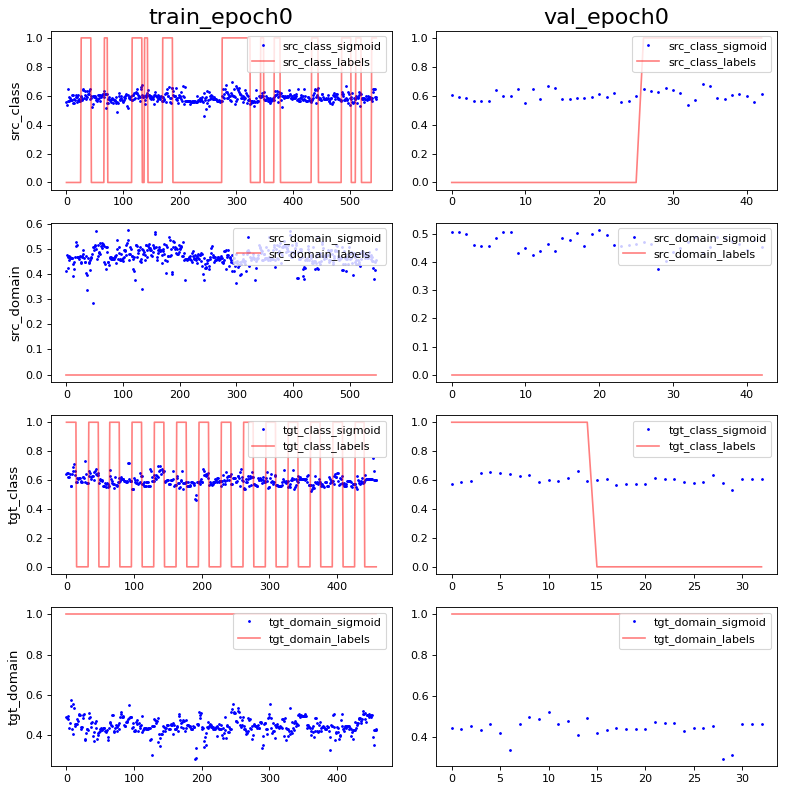

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -3.3672711e-09 1.0
PCA var: [30.199999 38.1      45.3      52.199997 56.199997 59.899998 62.6
 64.9      66.9      68.6     ]
show standardize mean and std: 6.274173e-09 0.98952854
PCA var: [26.499998 41.       52.6      59.8      66.1      71.299995 75.2
 78.399994 80.59999  82.69999 ]


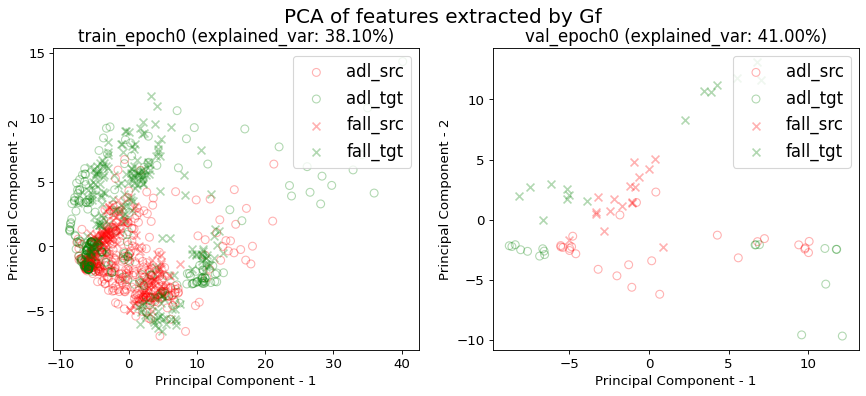

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


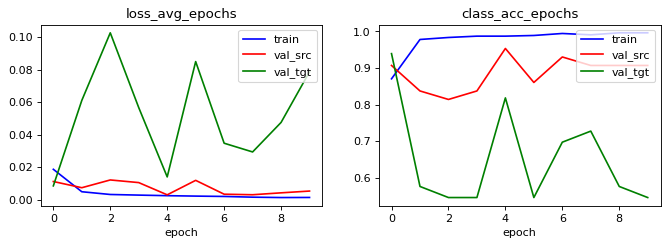

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.9799270072992701 0.03832116788321168 0.5145985401459854 0.8120437956204379
acc performance: 0.9069767441860465 0.046511627906976744 0.4186046511627907 0.7674418604651163


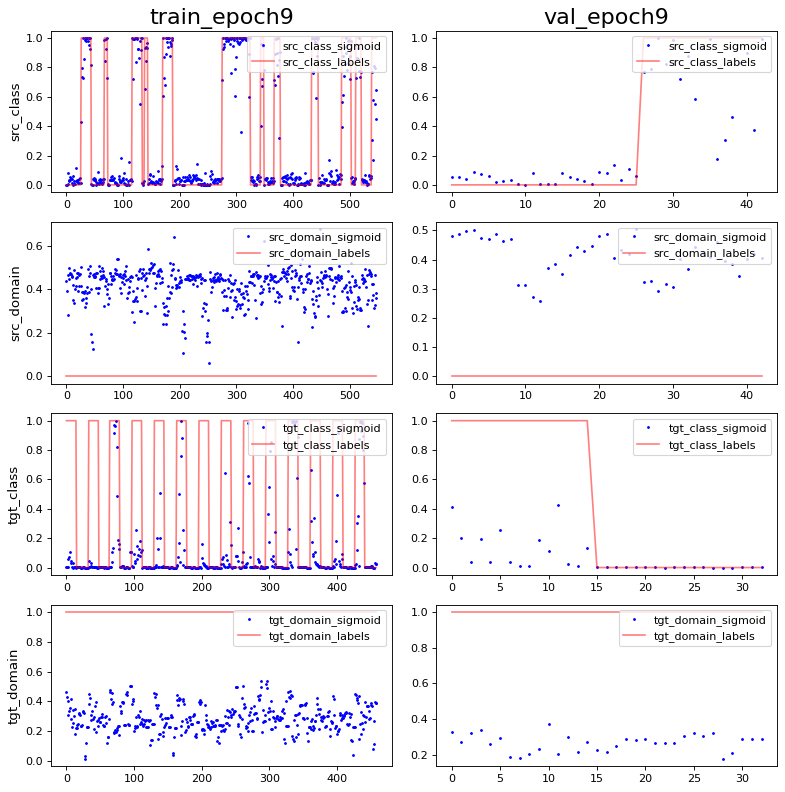

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 0.0 1.0
PCA var: [41.3      53.1      60.6      67.       70.8      73.200005 74.8
 76.4      77.8      79.      ]
show standardize mean and std: 0.0 1.0
PCA var: [41.800003 55.300003 64.8      70.4      74.4      77.4      80.3
 82.600006 84.700005 86.50001 ]


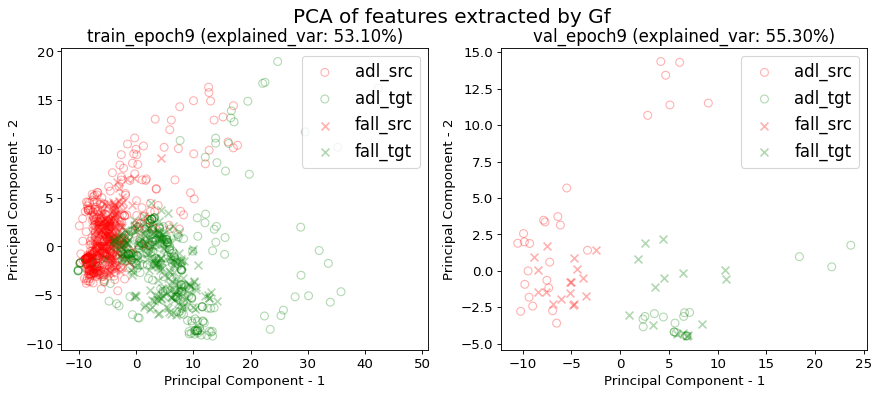

------------------------------Working on i_CV 9------------------------------
Working on get_UMAFall_loader...
train_data shape: (576, 3, 66)
val_data shape: (15, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3420138888888889 0.9322916666666666 0.3628472222222222 0.2847222222222222
acc performance: 0.0 1.0 1.0 0.6666666666666666


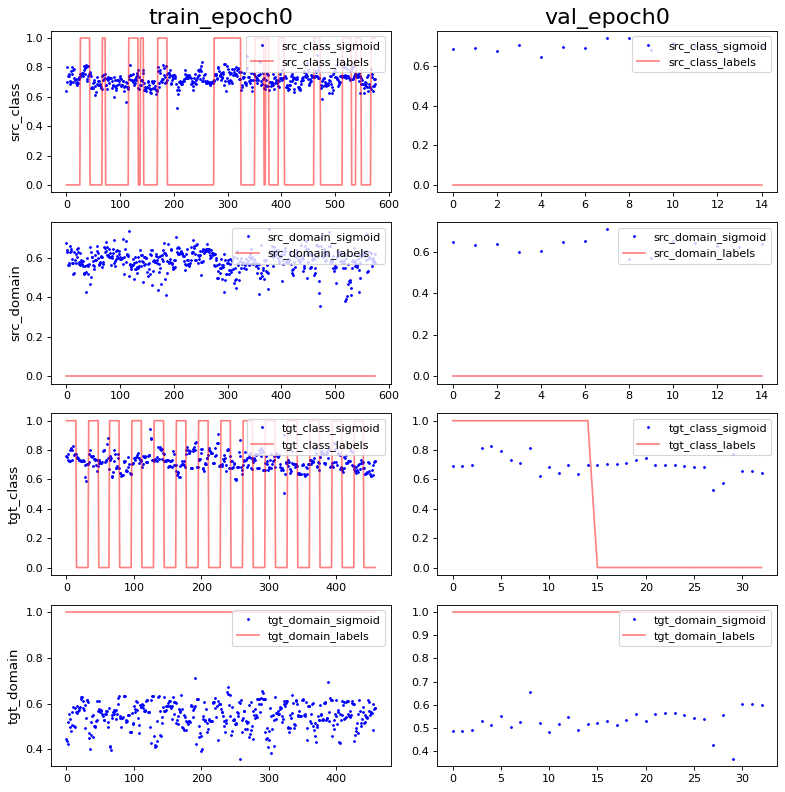

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 4.0952197e-10 0.9965218
PCA var: [24.8      37.5      46.5      53.6      57.899998 60.999996 63.699997
 66.1      67.9      69.6     ]
show standardize mean and std: 2.7594742e-09 0.9965218
PCA var: [24.8      42.3      52.3      60.8      68.       74.1      78.4
 82.200005 85.600006 88.200005]


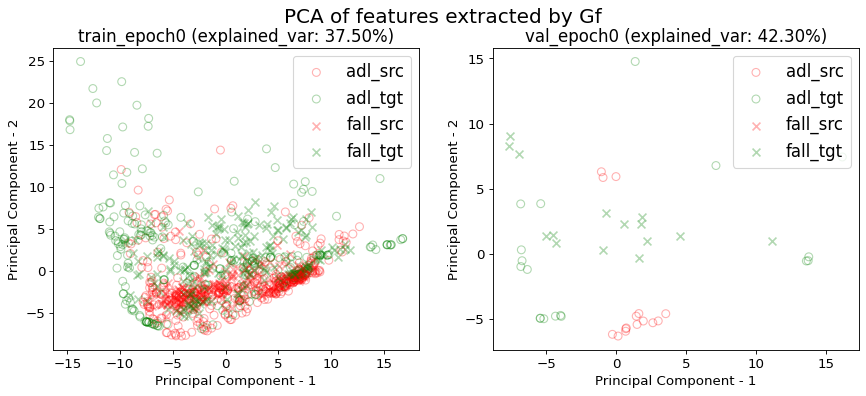

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


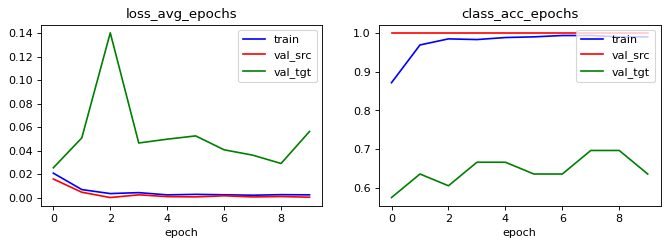

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.984375 0.7690972222222222 0.6059027777777778 0.7118055555555556
acc performance: 1.0 0.8666666666666667 1.4 1.6


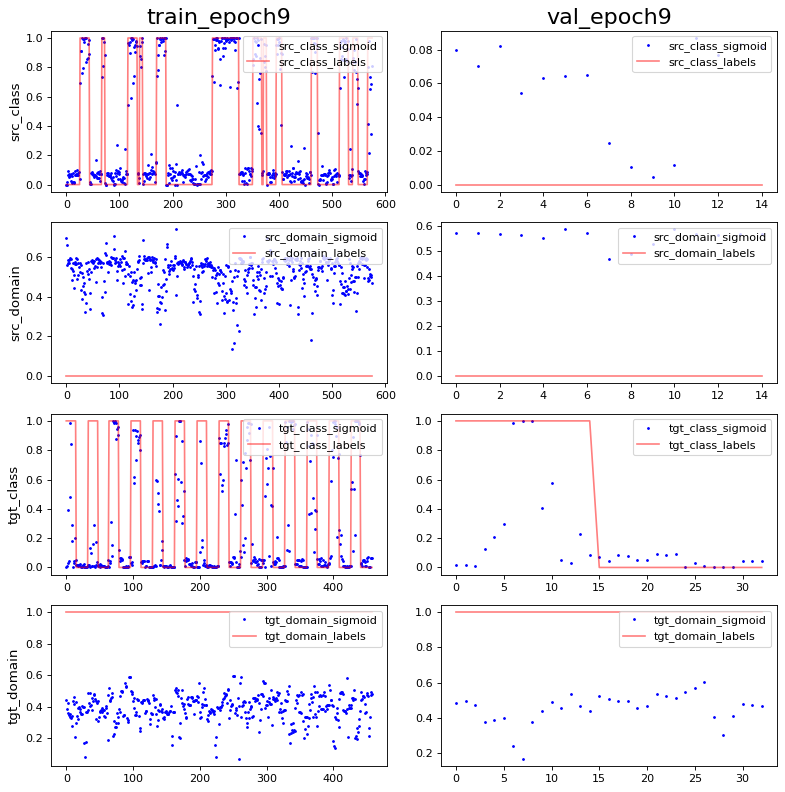

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 9.419006e-09 0.9965217
PCA var: [48.6      56.3      62.3      67.2      70.399994 72.59999  74.49999
 76.19999  77.79999  79.39999 ]
show standardize mean and std: -4.415159e-09 0.9965218
PCA var: [45.100002 60.100002 69.600006 78.50001  82.50001  85.40001  87.90001
 90.30001  92.30001  93.80001 ]


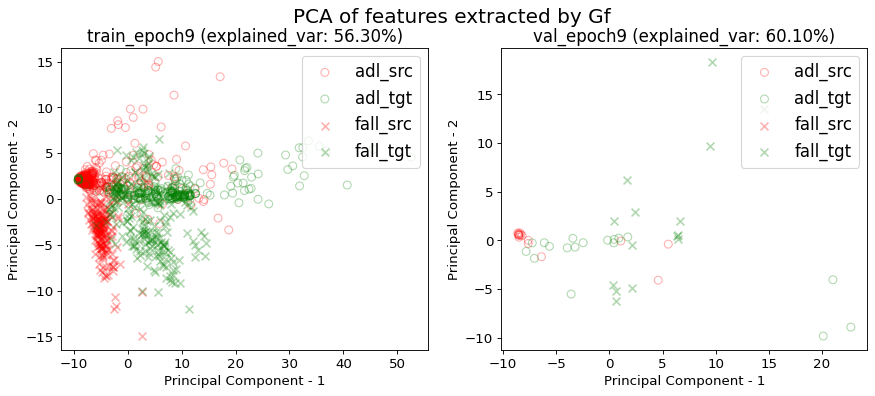

------------------------------Working on i_CV 10------------------------------
Working on get_UMAFall_loader...
train_data shape: (582, 3, 66)
val_data shape: (9, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3333333333333333 0.0859106529209622 0.3642611683848797 0.5171821305841925
acc performance: 0.6666666666666666 0.2222222222222222 1.6666666666666667 2.0


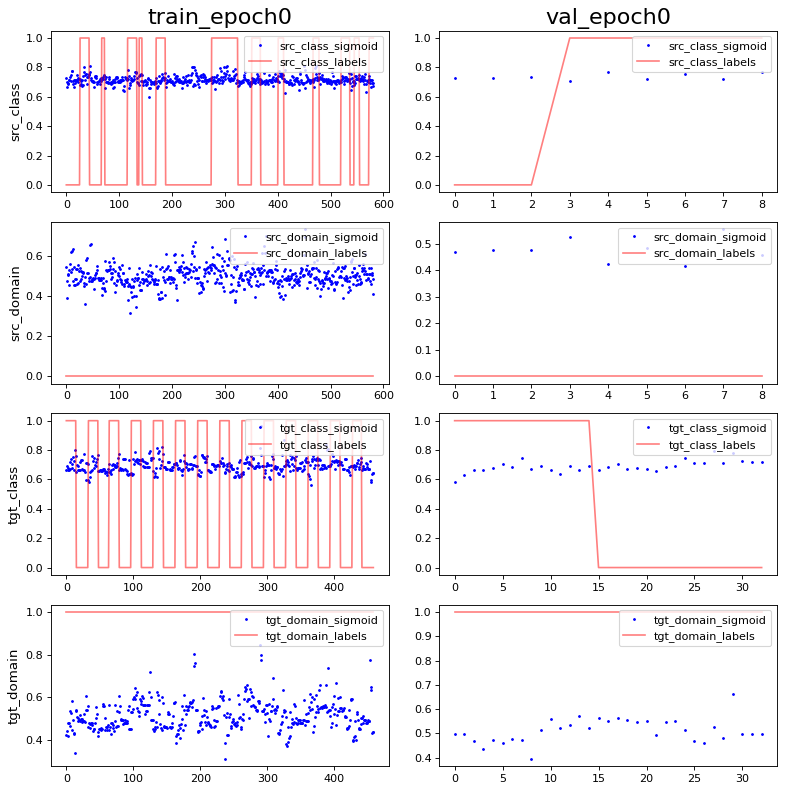

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 3.1555025e-09 0.9965217
PCA var: [30.000002 40.4      47.600002 52.7      56.2      59.3      62.1
 64.4      66.4      68.200005]
show standardize mean and std: 5.0458957e-09 0.9965218
PCA var: [38.3      53.3      62.2      68.6      74.299995 78.1      81.
 83.3      85.100006 86.8     ]


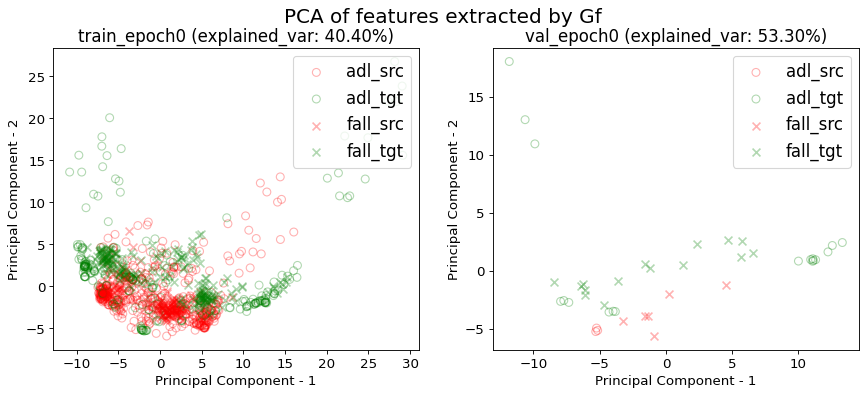

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


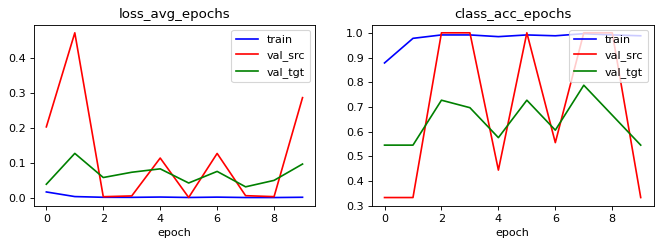

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.8178694158075601 1.0 0.46735395189003437 0.0
acc performance: 0.3333333333333333 1.0 2.0 0.0


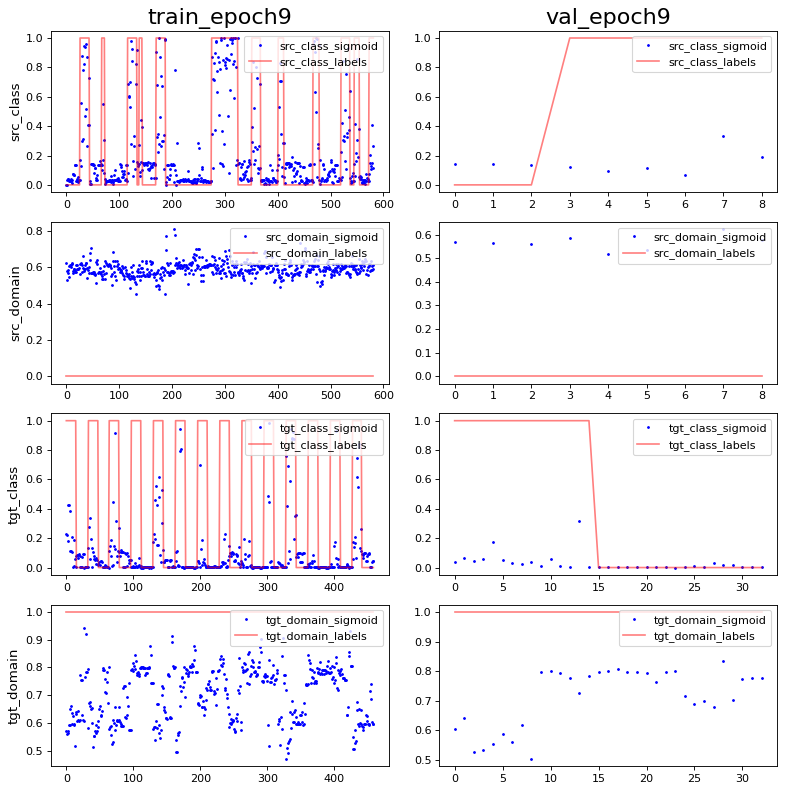

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 2.4022535e-08 1.0
PCA var: [47.3      60.3      67.1      70.7      74.2      76.6      78.299995
 79.899994 81.299995 82.399994]
show standardize mean and std: 2.0183583e-08 0.9965218
PCA var: [55.6      66.6      76.4      81.200005 85.100006 88.200005 90.700005
 92.200005 93.600006 94.600006]


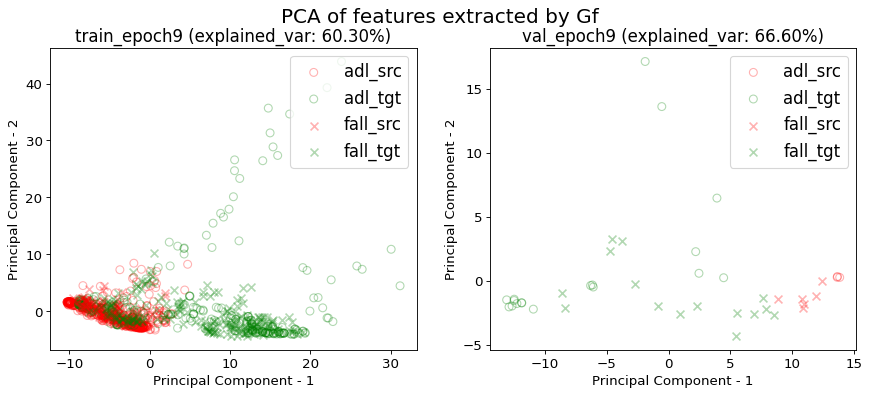

------------------------------Working on i_CV 11------------------------------
Working on get_UMAFall_loader...
train_data shape: (562, 3, 66)
val_data shape: (29, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3398576512455516 0.5658362989323843 0.3718861209964413 0.5124555160142349
acc performance: 0.3793103448275862 0.8620689655172413 0.5172413793103449 0.6206896551724138


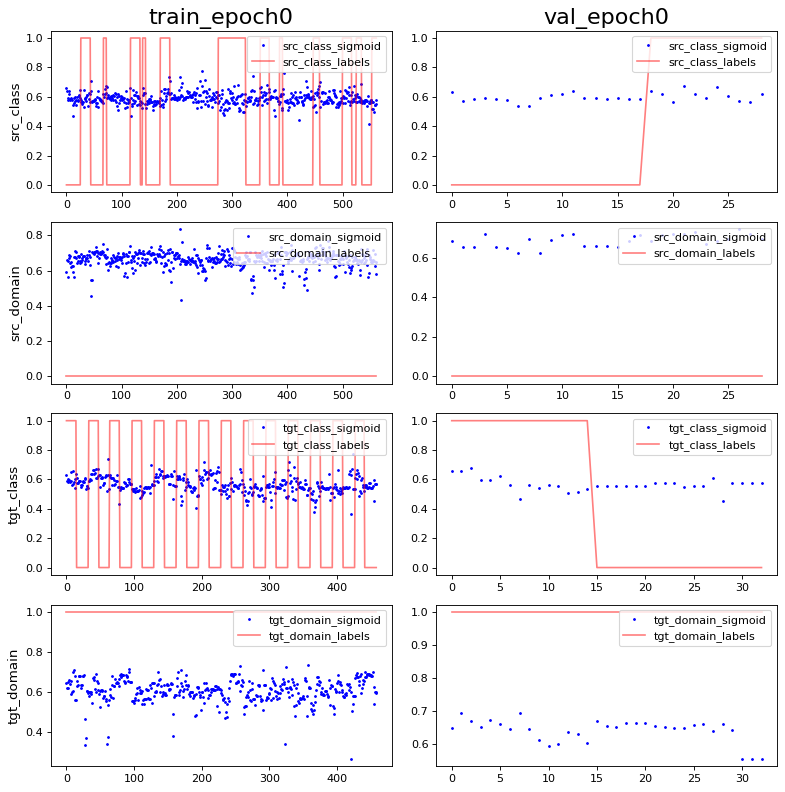

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -1.6605495e-09 0.9965218
PCA var: [15.9 28.  38.  43.6 48.3 52.1 55.6 58.  59.9 61.5]
show standardize mean and std: 0.0 0.99303126
PCA var: [21.199999 38.3      51.8      59.6      65.5      70.5      74.8
 78.700005 81.4      84.1     ]


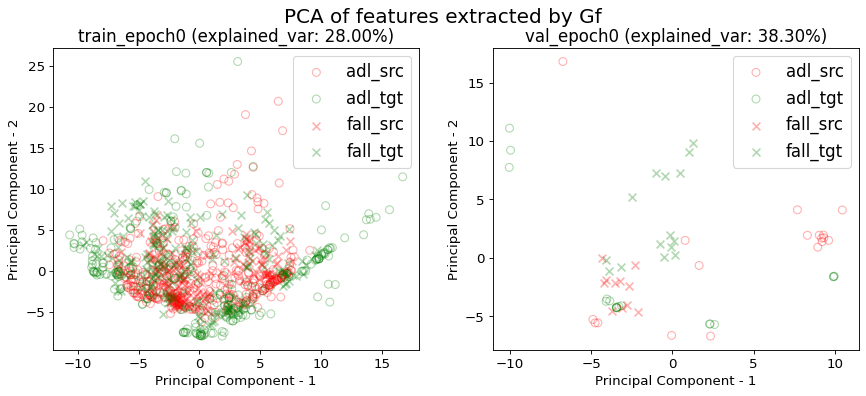

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


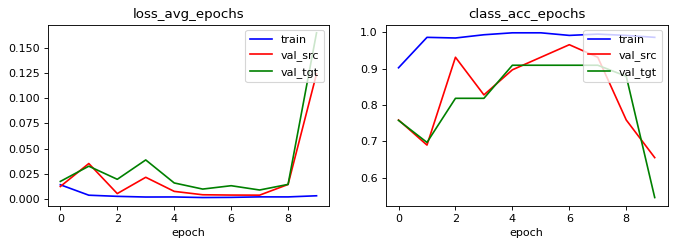

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.7295373665480427 0.0 0.44483985765124556 0.8167259786476868
acc performance: 0.6551724137931034 0.0 0.6206896551724138 1.1379310344827587


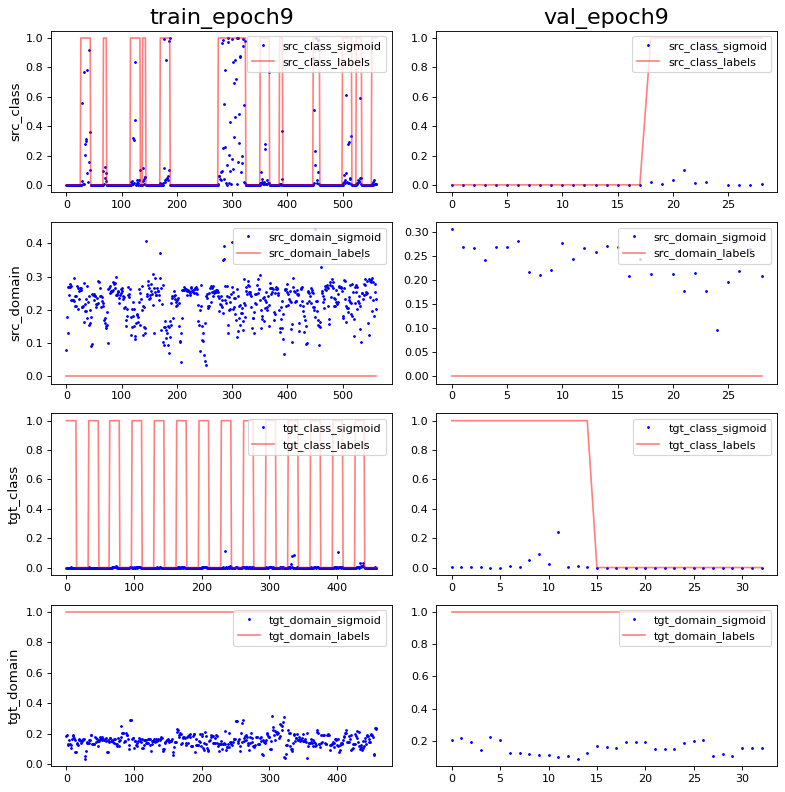

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -1.4944945e-08 0.939119
PCA var: [39.3      55.699997 63.799995 68.799995 72.2      74.799995 76.799995
 78.49999  80.09999  81.49999 ]
show standardize mean and std: 6.836375e-09 0.939119
PCA var: [50.6      62.1      71.1      77.5      80.8      83.700005 86.3
 88.4      90.200005 91.50001 ]


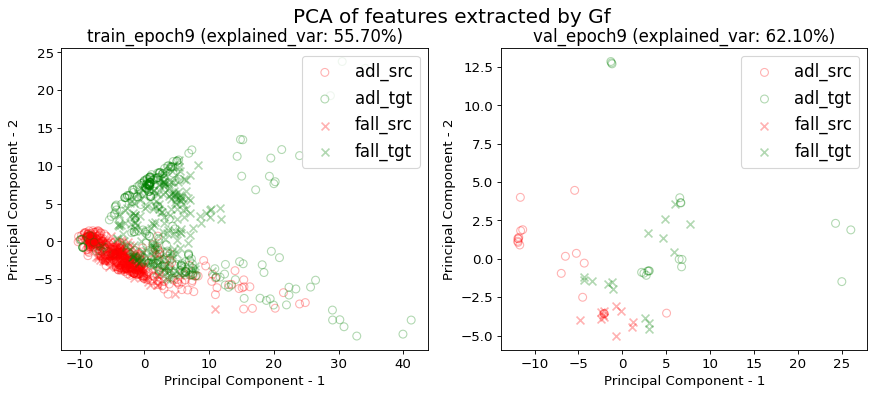

------------------------------Working on i_CV 12------------------------------
Working on get_UMAFall_loader...
train_data shape: (562, 3, 66)
val_data shape: (29, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.7473309608540926 0.037366548042704624 0.4697508896797153 0.7170818505338078
acc performance: 0.896551724137931 0.034482758620689655 0.5517241379310345 1.0689655172413792


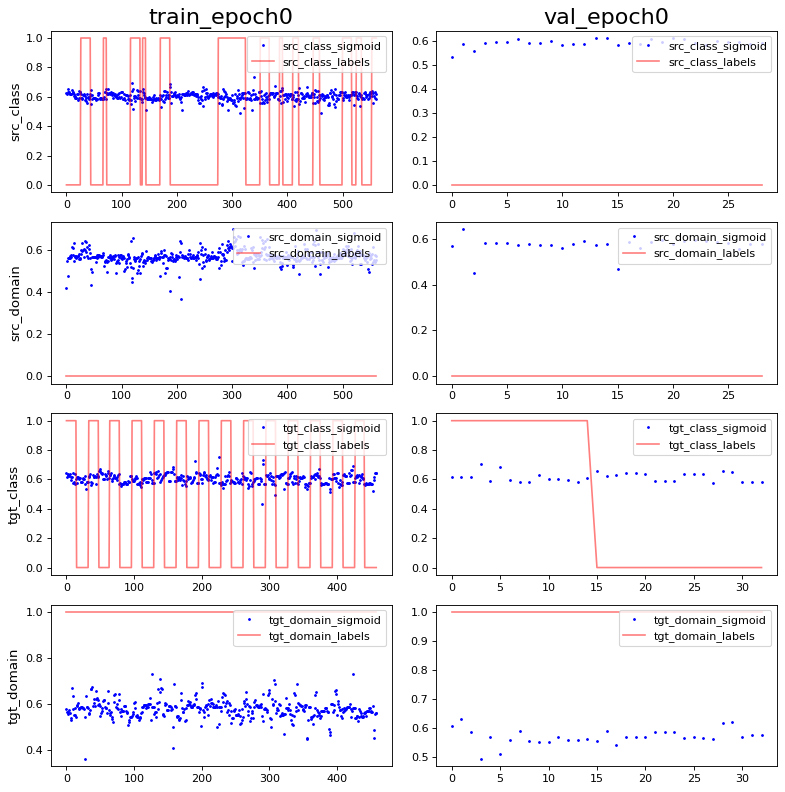

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -2.0756867e-09 0.9965218
PCA var: [25.5      41.2      48.       53.       57.       60.5      63.6
 65.799995 67.7      69.399994]
show standardize mean and std: -6.836375e-09 0.99303126
PCA var: [28.400002 46.800003 55.300003 62.700005 68.4      73.3      77.4
 80.8      83.600006 86.100006]


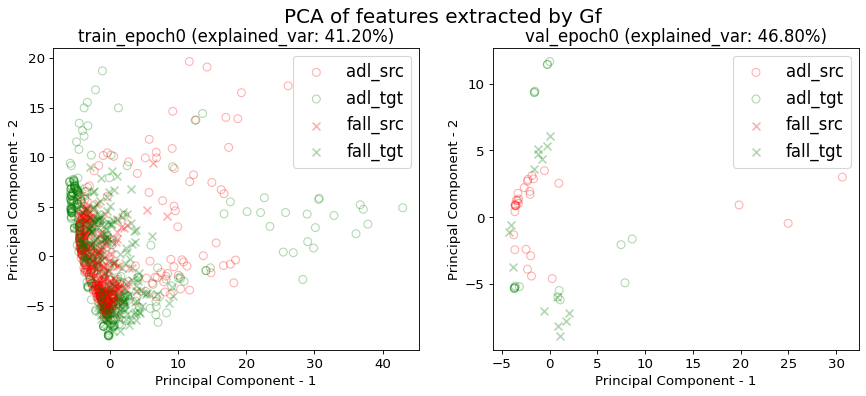

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


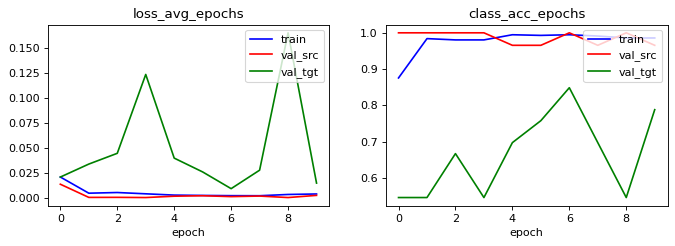

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.8683274021352313 0.8202846975088968 0.6494661921708185 0.1903914590747331
acc performance: 0.9655172413793104 0.9310344827586207 0.896551724137931 0.20689655172413793


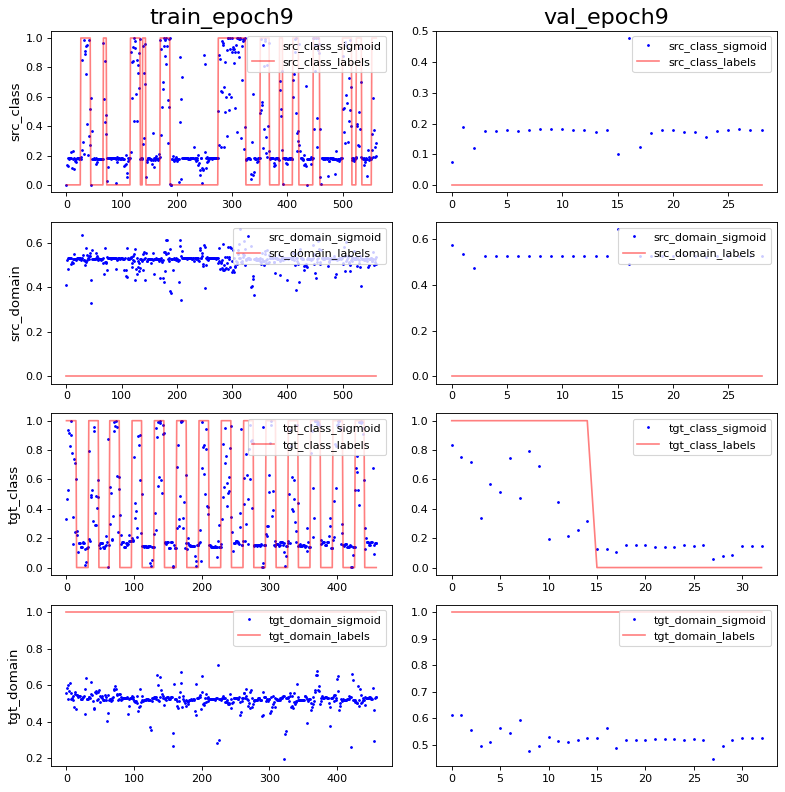

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: -4.1513735e-09 0.99999994
PCA var: [45.100002 53.100002 59.7      63.9      67.4      70.4      73.200005
 75.50001  77.600006 79.40001 ]
show standardize mean and std: 3.4181875e-09 1.0
PCA var: [26.       37.5      45.9      53.4      59.800003 65.3      70.8
 75.4      78.8      82.100006]


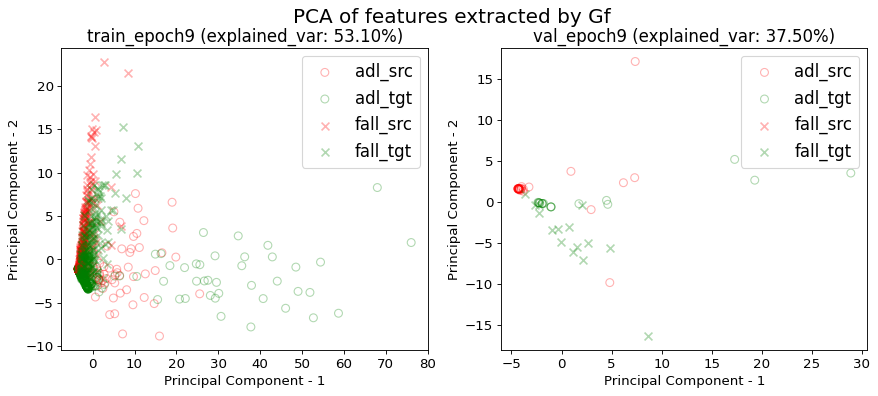

------------------------------Working on i_CV 13------------------------------
Working on get_UMAFall_loader...
train_data shape: (553, 3, 66)
val_data shape: (38, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (33, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.3616636528028933 0.969258589511754 0.37613019891500904 0.05786618444846293
acc performance: 0.47368421052631576 0.868421052631579 0.3684210526315789 0.02631578947368421


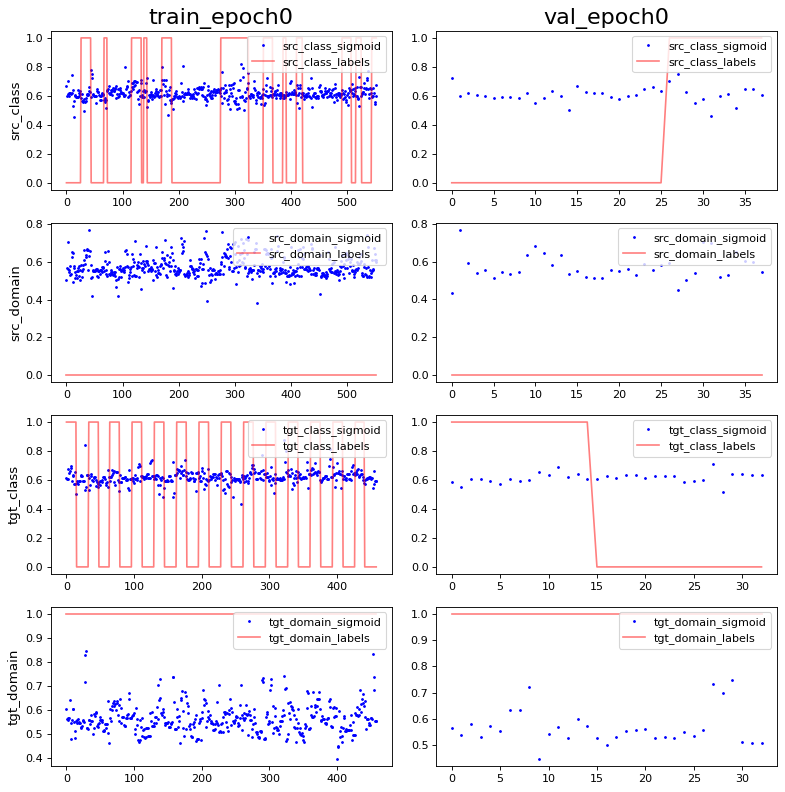

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
show standardize mean and std: 1.6753172e-09 1.0
PCA var: [18.3      30.699999 36.899998 42.1      46.699997 49.799995 52.299995
 54.499996 56.499996 58.299995]
show standardize mean and std: 0.0 0.9965218
PCA var: [17.9      31.3      40.399998 48.199997 53.799995 58.999996 63.499996
 67.299995 70.99999  73.99999 ]


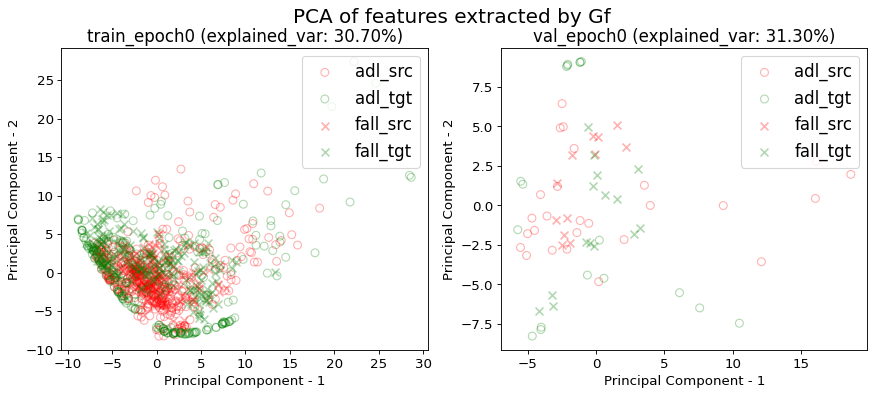

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/


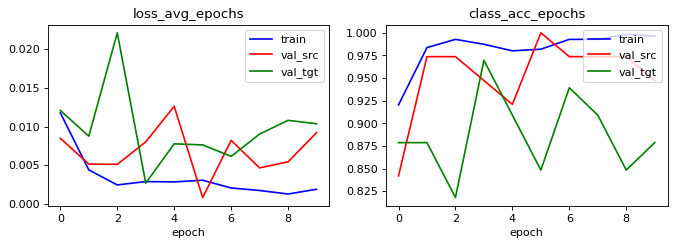

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UMAFall_wrist_UPFall_rightpocket/source/
acc performance: 0.9783001808318263 0.6455696202531646 0.6708860759493671 0.027124773960216998
acc performance: 0.9473684210526315 0.868421052631579 0.7631578947368421 0.02631578947368421


In [0]:
rep_n = 10

extractor_type = 'CNN'
num_epochs = 10
CV_n = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for i in range(0,rep_n):
  # start_time = time.time()

  df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
  # tasks_list = [('UMAFall_waist', 'UPFall_belt')]
  # tasks_list = [('UMAFall_ankle', 'UPFall_ankle')]
  # tasks_list = [('UPFall_belt', 'UMAFall_waist')]
  # tasks_list = [('UPFall_wrist', 'UMAFall_wrist')]
  tasks_list = [('UMAFall_wrist', 'UPFall_rightpocket')]

  optimal_training_params = {
      'classes_n': 2,
      'CV_n': CV_n,
      'num_epochs': num_epochs,
      'channel_n': 4,
      'batch_size': 16,
      'learning_rate': 0.01,
      'extractor_type': extractor_type,
      'device': device,}

  for task_item in tasks_list:
    start_time = time.time()
    (src_name, tgt_name) = task_item

    inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
    outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/{}_{}/'.format(src_name, tgt_name)
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)
    print('outputdir for stage2 output:', outputdir)

    df_performance_table = performance_table(df_performance_table, src_name, tgt_name, optimal_training_params, inputdir, outputdir)

    time_elapsed = time.time() - start_time
    print('time elapsed:', time_elapsed)
    df_performance_table.loc['time_elapsed'] = time_elapsed

    df_outputdir = outputdir+'repetitive_results/'
    if not os.path.exists(df_outputdir):
      os.makedirs(df_outputdir)

    print('df_performance_table saved at', outputdir)
    df_performance_table.to_csv(df_outputdir+'df_performance_table_rep10_i{}.csv'.format(i), encoding='utf-8')

    display(df_performance_table)


df_performance_table_all = get_rep10_stats(df_outputdir, rep_n)
display(df_performance_table_all)

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/

======================  train on source, val on target(source=UPFall_ankle to target=UMAFall_ankle)  ======================

------------------------------Working on i_CV 0------------------------------
Working on get_UPFall_loader...
train_data shape: (525, 3, 66)
val_data shape: (33, 3, 66)
Working on get_UMAFall_loader...
train_data shape: (486, 3, 66)
val_data shape: (44, 3, 66)
FeatureExtractor_total_params: 168
DannModel_total_params: 748
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/source/
acc performance: 0.4552380952380952 0.7238095238095238 0.25523809523809526 0.11428571428571428
acc performance: 0.45454545454545453 0.696969696969697 0.5454545454545454 0.06060606060606061


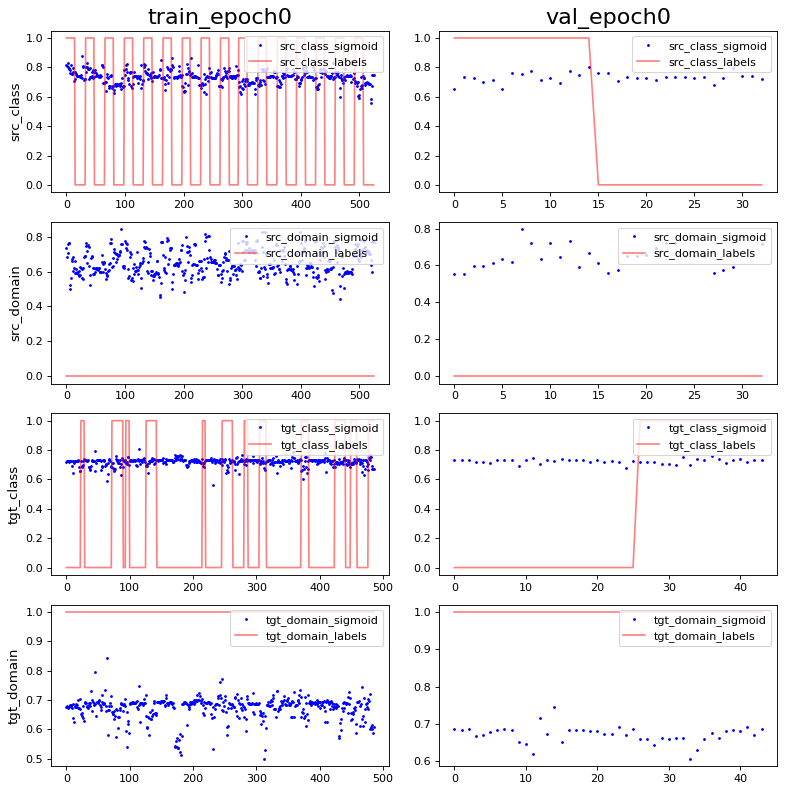

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/source/
show standardize mean and std: -2.4106506e-09 0.98952854
PCA var: [22.6 33.2 41.6 47.5 50.9 53.5 55.8 57.8 59.7 61.5]
show standardize mean and std: 1.3761534e-09 0.98601335
PCA var: [27.000002 39.5      48.1      53.699997 58.499996 63.099995 66.99999
 70.399994 73.49999  76.09999 ]


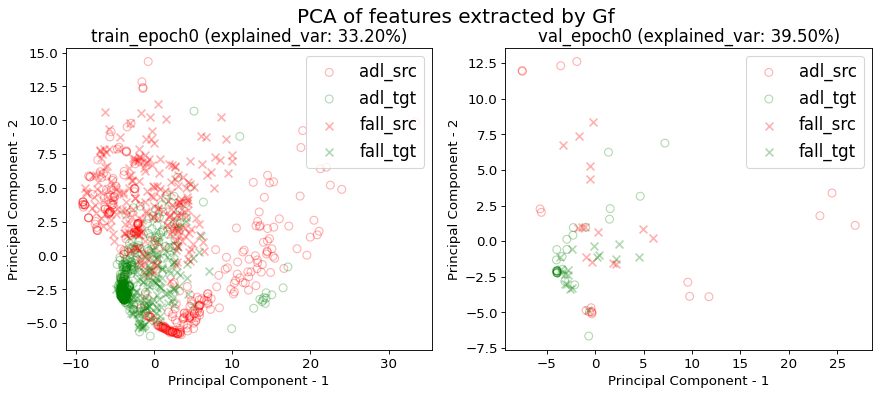

outputdir for baseline_learning_diagnosis output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/source/


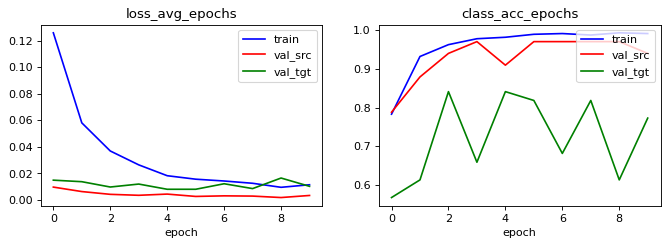

-----------------Exporting pytorch model-----------------
FeatureExtractor_total_params: 168
DannModel_total_params: 748
model saved successfully
-----------------Evaluating trained model-----------------
outputdir for model_output_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/source/
acc performance: 0.9942857142857143 0.7276190476190476 0.8114285714285714 0.07428571428571429
acc performance: 0.9393939393939394 0.6363636363636364 1.0303030303030303 0.09090909090909091


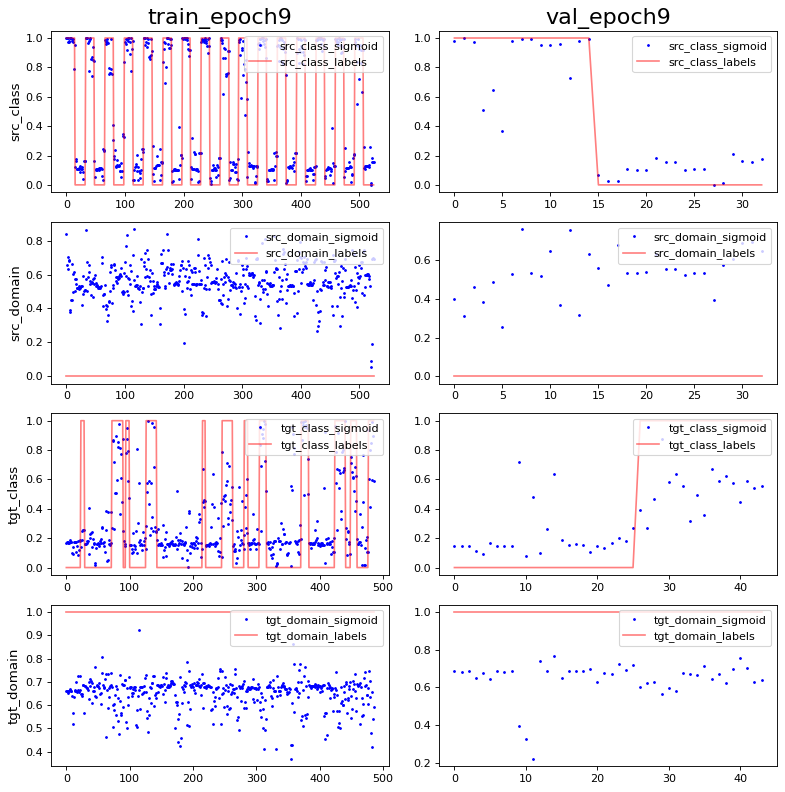

outputdir for model_features_diagnosis_trainval output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/UPFall_ankle_UMAFall_ankle/source/
show standardize mean and std: 4.1924358e-10 1.0
PCA var: [22.9 37.8 45.2 51.4 54.5 57.2 59.5 61.6 63.5 65.2]
show standardize mean and std: 5.5046137e-09 1.0
PCA var: [27.8      43.1      51.399998 57.6      62.6      66.9      70.5
 73.7      76.299995 78.899994]


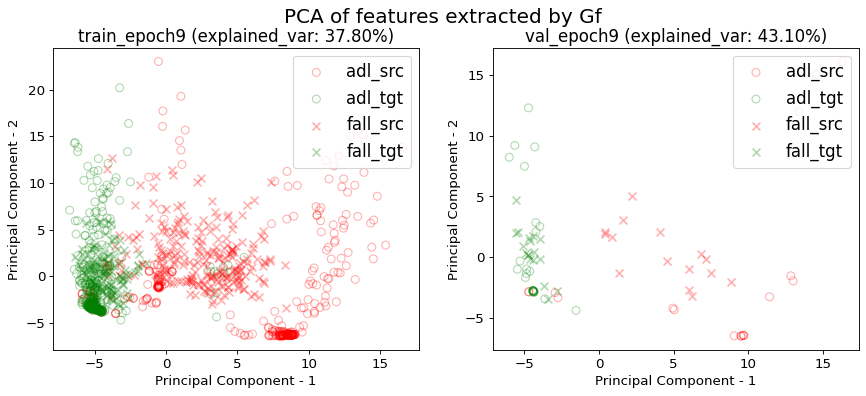

------------------------------Working on i_CV 1------------------------------
Working on get_UPFall_loader...


KeyboardInterrupt: ignored

In [0]:
# extractor_type = 'CNN'
# num_epochs = 10
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# for i in range(0,rep_n):
#   # start_time = time.time()

#   df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
#   # tasks_list = [('UMAFall_waist', 'UPFall_belt')]
#   # tasks_list = [('UMAFall_ankle', 'UPFall_ankle')]
#   tasks_list = [('UPFall_ankle', 'UMAFall_ankle')]


#   optimal_training_params = {
#       'classes_n': 2,
#       'CV_n': 17,
#       'num_epochs': 10,
#       'channel_n': 4,
#       'batch_size': 4,
#       'learning_rate': 0.001,
#       'extractor_type': extractor_type,
#       'device': device,}

#   for task_item in tasks_list:
#     start_time = time.time()
#     (src_name, tgt_name) = task_item

#     inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz_LOO/'
#     outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz_LOO/{}_{}/'.format(src_name, tgt_name)
#     if not os.path.exists(outputdir):
#         os.makedirs(outputdir)
#     print('outputdir for stage2 output:', outputdir)

#     df_performance_table = performance_table(df_performance_table, src_name, tgt_name, optimal_training_params, inputdir, outputdir)

#     time_elapsed = time.time() - start_time
#     print('time elapsed:', time_elapsed)
#     df_performance_table.loc['time_elapsed'] = time_elapsed

#     df_outputdir = outputdir+'/repetitive_results/'
#     if not os.path.exists(df_outputdir):
#       os.makedirs(df_outputdir)

#     print('df_performance_table saved at', outputdir)
#     df_performance_table.to_csv(df_outputdir+'df_performance_table_rep10_i{}.csv'.format(i), encoding='utf-8')

#     display(df_performance_table)


# df_performance_table_all = get_rep10_stats(df_outputdir, rep_n)
# display(df_performance_table_all)